<a href="https://colab.research.google.com/github/densmyslov/bq-hackathon/blob/main/notebooks/1_invoice_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Invoice Classification with BigQuery AI.


## Using PDFs and page images from Trump campaign filings

# Dataset description

The dataset consists of political campaign documents for Donald J. Trump, retrieved from the FCC’s public file system. These files—primarily multi-page PDFs and corresponding page images—include invoices, contracts, media orders, and other campaign finance records.  

A curated sample of ~300 documents was uploaded to a public Google Cloud Storage bucket, with both raw PDFs and rendered first-page images referenced in a BigQuery table. You can find the corresponding notebook [at this link](https://github.com/densmyslov/bq-hackathon/blob/main/notebooks/0_load_trump_pdfs_gcp_bucket.ipynb).

This dataset provides a challenging testbed for applying BigQuery AI functions to classify and extract structured information from unstructured, multimodal financial documents.

Notably, this dataset also provides a heuristic signal: almost all invoices include the term “inv” or “invoice” in their file names (in various cases)

# Setup

In [1]:
import os
import re
import pandas as pd
import requests
from io import BytesIO
from google.cloud import storage
import requests
import pytz
from datetime import datetime
import json
from typing import Dict, List, Any, Tuple, Optional
from collections import defaultdict
from PIL import Image
import matplotlib.pyplot as plt

In [2]:
from google.colab import auth
auth.authenticate_user()

from google.cloud import storage
gcs_client = storage.Client()

from google.cloud import bigquery
bq_client = bigquery.Client(project='data-science-455302')

In [3]:
bucket_name = BUCKET_NAME = 'trump-political-ads-sample'

# Functions

In [4]:
def show_image_page(bucket_name, blob_path):
  if blob_path.startswith('gs'):
    blob_path = '/'.join(blob_path.split('/')[3:])

  bucket = gcs_client.bucket(bucket_name)
  blob   = bucket.blob(blob_path)

  buf = BytesIO()
  blob.download_to_file(buf)
  buf.seek(0)
  return Image.open(buf)

def show_images(bucket_name, samples, n_cols = 4):
  # Setup grid
  n = len(samples)

  n_rows = (n + n_cols - 1) // n_cols  # ceiling division
  fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 4*n_rows))
  axes = axes.flatten()

  for i, (idx, row) in enumerate(samples.iterrows()):
      title = row['file_name']
      image_key = row['image_key']
      bucket_name = image_key.split('/')[2]
      blob_path = '/'.join(image_key.split('/')[3:])

      image = show_image_page(bucket_name, blob_path)

      axes[i].imshow(image)
      axes[i].set_title(title[:50], fontsize=8)  # shorten long titles
      axes[i].axis("off")

  # Hide unused axes
  for j in range(i+1, len(axes)):
      axes[j].axis("off")

  plt.tight_layout()
  plt.show()

def process_result(df):

  raw = df.iloc[0]["json_result"]

  # Strip markdown fences like ```json ... ```
  clean = re.sub(r"^```(?:json)?\s*|\s*```$", "", raw.strip(), flags=re.DOTALL)

  try:
      return json.loads(clean)

  except Exception as e:
      print("❌ JSON parse error:", e)
      print("Raw output:", raw[:500])

def calculate_gemini_cost(usage_metadata: dict,
                          input_rate: float = 0.00000125,
                          output_rate: float = 0.00001) -> float:
    """
    Calculate cost of a Gemini API call in USD.

    Args:
        usage_metadata (dict): The 'usage_metadata' field from the model response.
        input_rate (float): Price per 1k input tokens (default: $0.0025 for gemini-2.5-pro).
        output_rate (float): Price per 1k output tokens (default: $0.0100 for gemini-2.5-pro).

    Returns:
        float: Total cost in USD.
    """

    # Get counts
    prompt_tokens = usage_metadata.get("prompt_token_count", 0)
    candidate_tokens = usage_metadata.get("candidates_token_count", 0)

    # Input cost (prompt + reasoning tokens are billed at input rate)
    input_tokens = usage_metadata.get("total_token_count", 0) - candidate_tokens
    input_cost = (input_tokens / 1000) * input_rate

    # Output cost
    output_cost = (candidate_tokens / 1000) * output_rate

    return round(input_cost + output_cost, 6)


def upload_bytesio_to_gcs(buffer: BytesIO, gcs_uri: str, content_type: str = "application/octet-stream") -> None:
    """
    Upload an in-memory BytesIO buffer to Google Cloud Storage (GCS).

    Args:
        buffer (BytesIO): In-memory file (e.g. from pandas.to_parquet(..., BytesIO()))
        gcs_uri (str): Full GCS URI, e.g. "gs://trump-political-ads/fcc/tv_facilities.parquet"
        content_type (str): MIME type, e.g. "application/parquet", "application/pdf", "text/csv"
    """
    if not gcs_uri.startswith("gs://"):
        raise ValueError("gcs_uri must start with 'gs://'")

    # Parse bucket + blob
    parts = gcs_uri[5:].split("/", 1)
    bucket_name = parts[0]
    blob_name = parts[1]

    # Init client
    client = storage.Client()
    bucket = client.bucket(bucket_name)
    blob = bucket.blob(blob_name)

    # Ensure buffer pointer at start
    buffer.seek(0)

    # Upload from file-like object
    blob.upload_from_file(buffer, rewind=True, content_type=content_type)

    print(f"✅ Uploaded buffer → {gcs_uri}")

# Load table

In [5]:
PROJECT_ID = "data-science-455302"  # your GCP project
REGION = "us-central1"              # region of your connection / dataset
DATASET_ID = "trump_campaign_us_central1"         # dataset to store the remote model
MODEL_NAME = "mistral_medium"       # name for the remote model
SOURCE_TABLE = f"{PROJECT_ID}.{DATASET_ID}.TRUMP_PDF_FILES"
CONNECTION_RESOURCE = "24627479292.us-central1.576f28e4-61cc-464a-b136-da8b005649c8"

In [6]:
table = bq_client.get_table(SOURCE_TABLE)

## show document example

let's look at the first page of a random document from the table:

gs://trump-political-ads-sample/FCC/docs/277d0cec-2ece-ab9e-6277-8e1f222b6a4c/6267237 - Doanld J Trump for President - R INVOICE 1/page_1.png


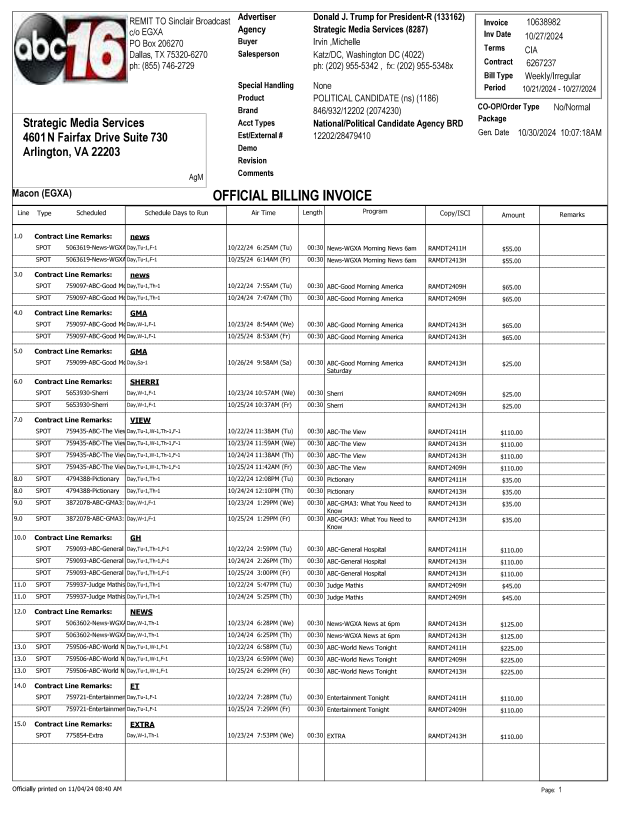

In [7]:

query = f"""
SELECT image_key
FROM `{SOURCE_TABLE}`
WHERE image_key IS NOT NULL
ORDER BY RAND()
LIMIT 1
"""

df = bq_client.query(query).to_dataframe()
image_uri = df['image_key'].tolist()[0]
print(image_uri)
image = show_image_page(bucket_name, image_uri)
image

## document truth labels
* invoices have string 'inv' (case invariant) int he file name; there are 4 invoices that do not have this string in the file name

* let's identify file_ids that belong to invoice truth labels

  

our sample table is quite small; to save code lines, we are going to shift the whole table into memory

In [8]:
table_df = bq_client.query(
    f"""SELECT * FROM `{SOURCE_TABLE}`"""
).to_dataframe()
table_df.shape

(298, 8)

In [9]:
table_df.sample(5)

pdf_key  \
48   gs://trump-political-ads-sample/FCC/docs/d8803...   
236  gs://trump-political-ads-sample/FCC/docs/eee8b...   
117  gs://trump-political-ads-sample/FCC/docs/e5a5a...   
67   gs://trump-political-ads-sample/FCC/docs/6e08d...   
292  gs://trump-political-ads-sample/FCC/docs/1834a...   

                                  file_id  \
48   d8803c5b-d189-357a-b751-12d9e9579d91   
236  eee8b1b7-44a3-69db-5ed0-a29c0984ef69   
117  e5a5a185-fe47-f45c-e90f-7ff7a5996462   
67   6e08da36-bd31-635b-2835-3c73f56b7fa4   
292  1834af6f-6c73-83c7-c3c8-1138faef6964   

                                             file_name  \
48   Trump General NAB Est 11653 and more - RAMDT24...   
236  Trump for President Est. 11733 9.3 thru 9.9.24...   
117           DONALD TRUMP FOR PRES- 4584304-1 INVOICE   
67          K5-Donald J Trump for President-NAB-475627   
292                            Trump - Media Plan 11.2   

                                             image_key  is_invoice_pdf  \
48   gs://trump-political-ads-sample/FCC/docs/d8803...           False   
236  gs://trump-political-ads-sample/FCC/docs/eee8b...            True   
117  gs://trump-political-ads-sample/FCC/docs/e5a5a...            True   
67   gs://trump-political-ads-sample/FCC/docs/6e08d...            True   
292  gs://trump-political-ads-sample/FCC/docs/1834a...           False   

     is_invoice_img doc_class_img doc_class_pdf  
48             True      contract         order  
236           False         order         order  
117            True       invoice       invoice  
67            False       invoice      contract  
292           False         other         other

##### true_file_ids

In [42]:
true_file_ids = table_df.query("file_name.str.contains('inv', case=False, regex=True, na=False)").file_id.unique()
true_file_ids = list(true_file_ids)

add_inv_ids = ['9e220dc3-65ea-85e7-99f9-73a4b9d7192c',
               '6409dca3-38eb-d3aa-9956-5db95a576e2c',
               '9d24a9a2-2cb9-e0eb-1c01-aaabfa1e47e5',
               '80df35b0-51f7-3918-3e8c-0308c0959723',
               'a3de76be-b796-a834-a3e7-96b2d0c7ff21',
               '44686740-5ce8-79de-72ad-3215ca69a0a1',
               '51271a2d-bbb8-95ef-9aa9-99904bfe1caa']

true_file_ids = true_file_ids + add_inv_ids
print(len(true_file_ids))

69


* we got 69 as the  number of invoices in the table consisting of 298 rows with documents.

* we will use this number to estimate the accuracy of  classifications

# Invoice classification

## model_endpoint: gemini-2.5-pro

In [10]:
model_endpoint = MODEL_ENDPOINT = 'gemini-2.5-pro'

## Step 1. Invoice classification: AI.GENERATE_BOOL

* we will be using [AI.GENERATE_BOOL](https://cloud.google.com/bigquery/docs/reference/standard-sql/bigqueryml-syntax-ai-generate-bool) function

### One-row smoke test

#### Smoke Test – Single Image Classification

This query tests the AI.GENERATE_BOOL function on one sample document image to confirm that the model and connection are working before scaling to the full dataset.

In [ ]:
sql = f"""
WITH src AS (
  SELECT
    image_key,
    REPLACE(
      REPLACE(image_key,
              'gs://trump-political-ads-sample/',
              'https://storage.googleapis.com/trump-political-ads-sample/'),
      ' ', '%20'
    ) AS url
  FROM `{SOURCE_TABLE}`
  WHERE REGEXP_CONTAINS(image_key, r'(?i)\\.png$')  -- case-insensitive .png
  LIMIT 1
)
SELECT
  image_key,
  r.result        AS is_invoice,
  r.full_response AS full_response
FROM src,
UNNEST([AI.GENERATE_BOOL(
  ('Is this an invoice? Answer strictly True or False.', url),
  connection_id => '{CONNECTION_RESOURCE}',
  endpoint      => '{model_endpoint}'
)]) AS r
"""

df = bq_client.query(sql).to_dataframe()



we added the following 3 fields to the output:
* image_key of the first page of the invoice
* is_invoice: classification result (BOOL)
* full_response

In [ ]:
df

image_key  is_invoice  \
0  gs://trump-political-ads-sample/FCC/docs/d560d...       False   

                                       full_response  
0  {"candidates":[{"avg_logprobs":-25.37227545844...

let's check the image of the first page of the document we classified:

gs://trump-political-ads-sample/FCC/docs/d560d6ca-31f2-9917-28a6-10af7404d348/_MAGA Inc. NAB PB-19 (Signed)_2/page_1.png
trump-political-ads-sample FCC/docs/d560d6ca-31f2-9917-28a6-10af7404d348/_MAGA Inc. NAB PB-19 (Signed)_2/page_1.png


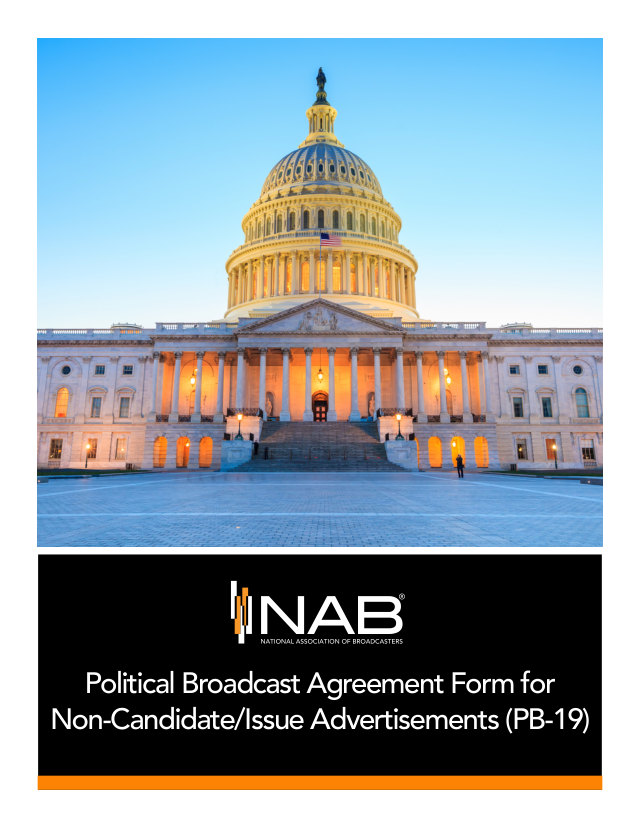

In [ ]:
page_image_key = df['image_key'].tolist()[0]
print(page_image_key)

bucket_name = page_image_key.split('/')[2]
blob_path   = '/'.join(page_image_key.split('/')[3:])
print(bucket_name, blob_path)
image = show_image_page(bucket_name, blob_path)
image

In [ ]:
resp = df['full_response'].tolist()[0]
resp = json.loads(resp)
resp

{'candidates': [{'avg_logprobs': -23.480487060546874,
   'content': {'parts': [{'text': '{"answer": false}'}], 'role': 'model'},
   'finish_reason': 'STOP',
   'score': -117.40243530273438}],
 'create_time': '2025-09-21T23:29:07.600685Z',
 'model_version': 'gemini-2.5-pro',
 'response_id': 'Q4rQaO3UJPOThMIPsuntuQQ',
 'usage_metadata': {'billable_prompt_usage': {'text_count': 204},
  'candidates_token_count': 5,
  'candidates_tokens_details': [{'modality': 'TEXT', 'token_count': 5}],
  'prompt_token_count': 99,
  'prompt_tokens_details': [{'modality': 'TEXT', 'token_count': 99}],
  'thoughts_token_count': 564,
  'total_token_count': 668,
  'traffic_type': 'ON_DEMAND'}}

In [ ]:
cost = calculate_gemini_cost(resp['usage_metadata'])
print(f"Cost: $ {cost: .6f}")

Cost: $  0.000001


full_response includes, among others:
* avg_logprobs show the probability assigned to the answer chosen by the model; the lower avg_logprobs to 0, the more confident the model is;  
* finish_reason `STOP` means normal completion (model decided it’s done).
* usage metadata shows quite a conservative consumption of tokens:
  * 'candidates_token_count' (number of completion tokens)is always 5 for False and 4 for True in AI.GENERATE_BOOL
  * `thoughts_token_count` is quite conservative
  * `prompt token count` is the numbre of tokens the model assigned to the image

#### Smoke Test – Single PDF Classification
Here we classify the same document, but using its PDF instead of an image, to compare accuracy between formats.

In [ ]:
pdf_key = image_key.replace('page_1.png','doc.pdf')
print(pdf_key)

sql = f"""
WITH src AS (
  SELECT
    pdf_key,
    REPLACE(
      REPLACE(pdf_key,
              'gs://trump-political-ads-sample/',
              'https://storage.googleapis.com/trump-political-ads-sample/'),
      ' ', '%20'
    ) AS url
  FROM `{SOURCE_TABLE}`
  WHERE REGEXP_CONTAINS(pdf_key, r'(?i)\\.pdf$')  -- case-insensitive .pdf
  QUALIFY ROW_NUMBER() OVER (ORDER BY pdf_key) = 1 -- deterministic single sample
)
SELECT
  pdf_key,
  r.result        AS is_invoice,
  r.status        AS status,
  r.full_response AS full_response
FROM src,
UNNEST([AI.GENERATE_BOOL(
  ('Is this an invoice? Answer strictly True or False.', url),
  connection_id => '{CONNECTION_RESOURCE}',
  endpoint      => '{model_endpoint}'
)]) AS r
"""
df = bq_client.query(sql).to_dataframe()


gs://trump-political-ads-sample/FCC/docs/02d41cf6-ef29-bb8a-4133-aabf796f6d24/DONALD J TRUMP PRESIDENT 2024 WWJ INVOICE 190045389/doc.pdf


In [ ]:
df

pdf_key  is_invoice status  \
0  gs://trump-political-ads-sample/FCC/docs/02d41...       False          

                                       full_response  
0  {"candidates":[{"avg_logprobs":-6.426045989990...

This time, using the pdf file of the document, the model correctly classified our document as not an invoice ("is_invoice" == False)

In [ ]:
resp = df['full_response'].tolist()[0]
resp = json.loads(resp)
resp

{'candidates': [{'avg_logprobs': -20.644807434082033,
   'content': {'parts': [{'text': '{"answer": true}'}], 'role': 'model'},
   'finish_reason': 'STOP',
   'score': -103.22403717041016}],
 'create_time': '2025-09-20T05:08:31.887065Z',
 'model_version': 'gemini-2.5-pro',
 'response_id': 'zzbOaJmSNqnuhMIPgYu_sAY',
 'usage_metadata': {'billable_prompt_usage': {'text_count': 227},
  'candidates_token_count': 5,
  'candidates_tokens_details': [{'modality': 'TEXT', 'token_count': 5}],
  'prompt_token_count': 113,
  'prompt_tokens_details': [{'modality': 'TEXT', 'token_count': 113}],
  'thoughts_token_count': 609,
  'total_token_count': 727,
  'traffic_type': 'ON_DEMAND'}}

our "smoke test" request showed:
* we should make requests using both image and pdf files, and compare reaults after that;  

* quite a reasonable the token usage

### all rows classification using AI.BOOL function

#### Classify All PDF Files
Let's classify  documents using the entire PDF files. This provides a more complete context for the model, at the expense of higher token usage.

* we stored entire pdf files of the dataset in bucket and put links to these files in the column `pdf_key` of the SOURCE_TABLE.


In [12]:
DEST_TABLE = f"{PROJECT_ID}.{DATASET_ID}.TRUMP_PDF_FLAGS"

sql = f"""
CREATE OR REPLACE TABLE `{DEST_TABLE}` AS
WITH src AS (
  SELECT
    pdf_key,
    -- Convert gs://... -> https://storage.googleapis.com/... and URL-encode spaces
    REPLACE(
      REPLACE(pdf_key, 'gs://', 'https://storage.googleapis.com/'),
      ' ', '%20'
    ) AS url
  FROM `{SOURCE_TABLE}`
  WHERE pdf_key IS NOT NULL
    AND REGEXP_CONTAINS(pdf_key, r'(?i)\\.pdf$')  -- case-insensitive .pdf
),
calls AS (
  SELECT
    pdf_key,
    AI.GENERATE_BOOL(
      ('Is this document an invoice? Answer strictly True or False.', url),
      connection_id => '{CONNECTION_RESOURCE}',
      endpoint      => '{model_endpoint}'
    ) AS r
  FROM src
)
SELECT
  pdf_key,
  r.result        AS is_invoice,
  r.status        AS status,
  r.full_response AS full_response
FROM calls
"""
bq_client.query(sql).result()
print("✅ Created with full_response:", DEST_TABLE)


✅ Created with full_response: data-science-455302.trump_campaign_us_central1.TRUMP_PDF_FLAGS


##### gather model output statistics

In [13]:
df = bq_client.query(f"""
SELECT * FROM `{DEST_TABLE}`
""").to_dataframe()
df.shape

(298, 4)

In [36]:
df['avg_logprobs'] = df['full_response'].apply(lambda x:
                                               json.loads(x)['candidates'][0]['avg_logprobs'])
df['prompt_token_count'] = df['full_response'].apply(lambda x:
                                        json.loads(x)['usage_metadata']['prompt_token_count'])
df['thoughts_token_count'] = df['full_response'].apply(lambda x:
                                        json.loads(x)['usage_metadata']['thoughts_token_count'])
df['usage_metadata'] = df['full_response'].apply(lambda x:
                                        json.loads(x)['usage_metadata'])

df['src'] = 'pdf'

df['file_id'] = df['pdf_key'].str.split('/').str[5]
df['file_name'] = df['pdf_key'].str.split('/').str[6]
df.rename(columns={'pdf_key':'file_key'}, inplace=True)

##### distr of avg_logprobs

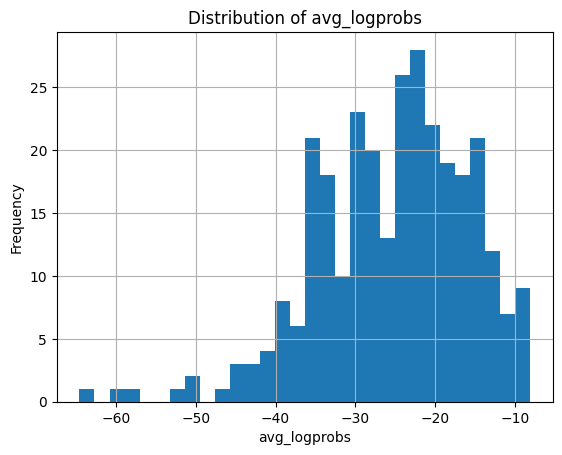

In [15]:
df['avg_logprobs'].hist(bins=30)
plt.xlabel("avg_logprobs")
plt.ylabel("Frequency")
plt.title("Distribution of avg_logprobs")
plt.show()

* Distribution of avg_logprobs shows that the model is not confident of its completion results: most avg_logprobs lie in the interval of `-15 to - 40`. the model is slightly more unconfident about its results as when it used first-page image (`-15 to -30`). And the level of confidence is again very low.

* As with the classification using images, this is quite a surprising result for the seemingly simple document classification task

##### distribution of thoughts tokens

In [16]:
df['thoughts_token_count'].sum().item()

223290

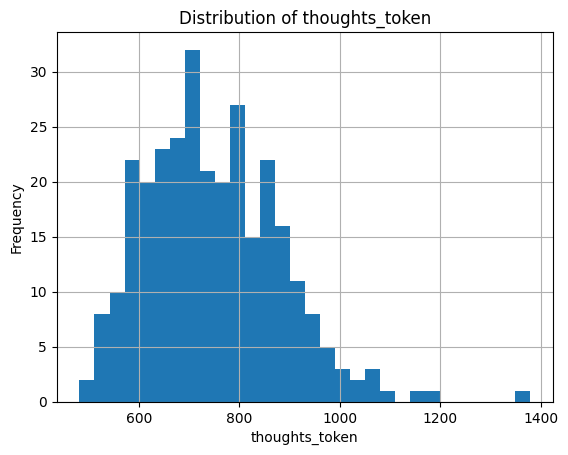

In [17]:
df['thoughts_token_count'].hist(bins=30)
plt.xlabel("thoughts_token")
plt.ylabel("Frequency")
plt.title("Distribution of thoughts_token")
plt.show()

##### most difficult pdf files
let's see which documents consumed most thought tokens and were assigned the lowest avg_probs

In [37]:
samples = df.query("thoughts_token_count >1000 & avg_logprobs < -45").copy()
samples['file_name'] = samples['file_key'].apply(lambda x: x.split('/')[-2])
samples['image_key'] = samples['file_key'].apply(lambda x: x.replace('doc.pdf','page_1.png'))
samples

file_key  is_invoice status  \
54   gs://trump-political-ads-sample/FCC/docs/94daf...       False          
84   gs://trump-political-ads-sample/FCC/docs/c528b...       False          
97   gs://trump-political-ads-sample/FCC/docs/e0865...       False          
263  gs://trump-political-ads-sample/FCC/docs/3fa6b...        True          
274  gs://trump-political-ads-sample/FCC/docs/bbe3e...        True          

                                         full_response  avg_logprobs  \
54   {"candidates":[{"avg_logprobs":-45.40476989746...    -45.404770   
84   {"candidates":[{"avg_logprobs":-50.093359375,"...    -50.093359   
97   {"candidates":[{"avg_logprobs":-46.97467041015...    -46.974670   
263  {"candidates":[{"avg_logprobs":-50.14730224609...    -50.147302   
274  {"candidates":[{"avg_logprobs":-58.09544677734...    -58.095447   

     prompt_token_count  thoughts_token_count  \
54                   99                  1098   
84                  113                  1046   
97                  129                  1010   
263                 117                  1006   
274                 121                  1379   

                                        usage_metadata  src  \
54   {'billable_prompt_usage': {'text_count': 215},...  pdf   
84   {'billable_prompt_usage': {'text_count': 236},...  pdf   
97   {'billable_prompt_usage': {'text_count': 247},...  pdf   
263  {'billable_prompt_usage': {'text_count': 239},...  pdf   
274  {'billable_prompt_usage': {'text_count': 246},...  pdf   

                                  file_id  \
54   94dafe16-b4a3-ce67-8416-fa6336025a3b   
84   c528be72-86f8-0bc6-0308-cddc1965cf26   
97   e0865ade-9e79-f162-9f83-798616fc2e10   
263  3fa6b0c6-f1cc-55d5-aa5d-f4c98bf4cd64   
274  bbe3eb63-f3ad-a736-8b11-c41abc72d96d   

                                             file_name  \
54                 WWMT TRUMP FOR PRESIDENT SEPT 24-30   
84   DONALD J TRUMP PRESIDENT 2024 KYW CONTRACT 649...   
97   Donald J.Trump for President C4556964 8-13-24 ...   
263  WZAW Donald J Trump for President 9.17-9.23 es...   
274  Trump - R - President - WPTZ - 01-02-2024 - RE...   

                                             image_key  
54   gs://trump-political-ads-sample/FCC/docs/94daf...  
84   gs://trump-political-ads-sample/FCC/docs/c528b...  
97   gs://trump-political-ads-sample/FCC/docs/e0865...  
263  gs://trump-political-ads-sample/FCC/docs/3fa6b...  
274  gs://trump-political-ads-sample/FCC/docs/bbe3e...

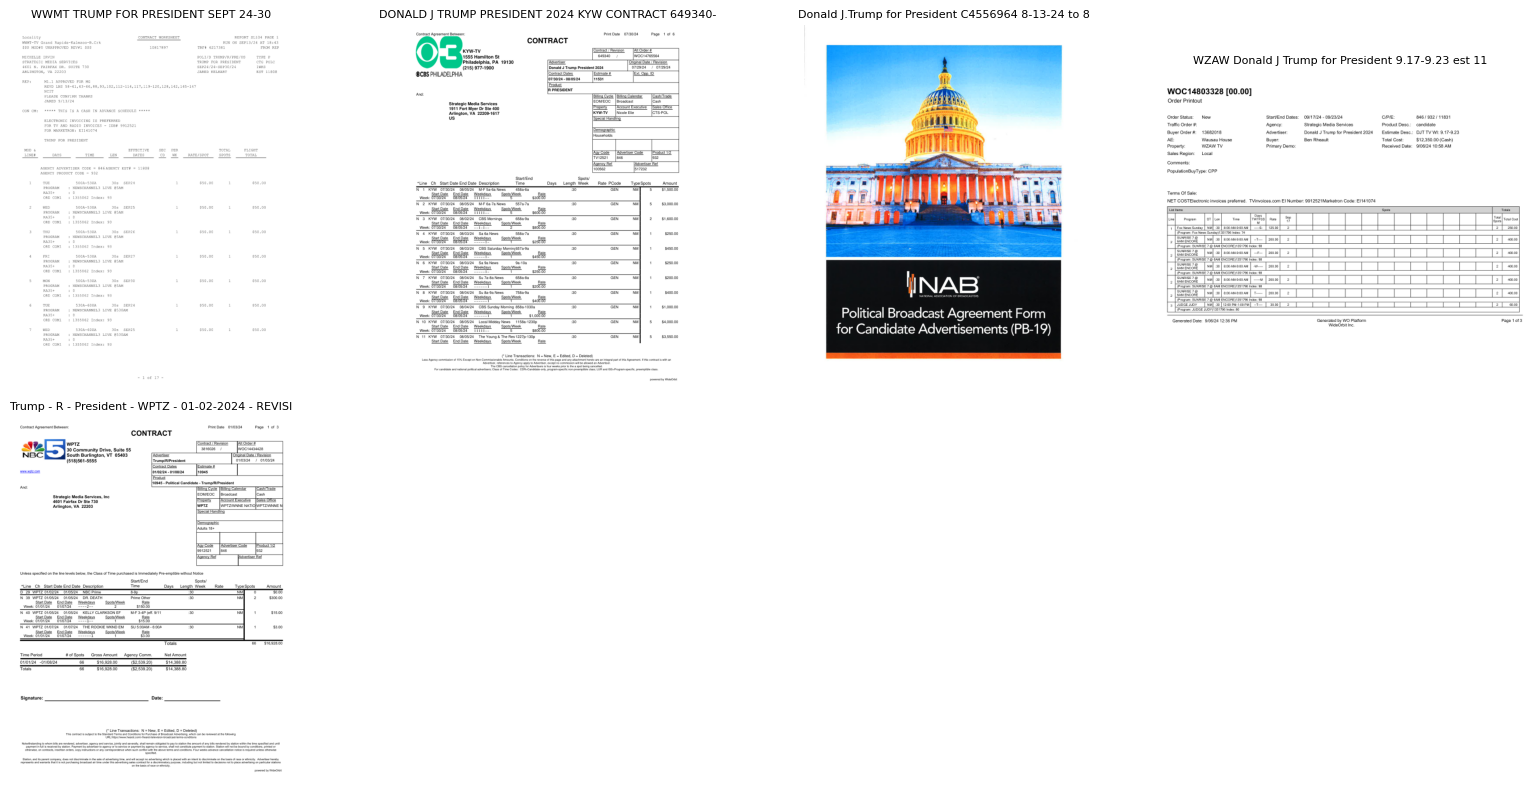

In [38]:
show_images(bucket_name, samples, n_cols = 4)

the model spent most thought tokens and assigned lowest avg_probs to correctly classify 4 documents as is_invoice = False. Remarkably, only one (the rightmost in the Figure above) document of the 4 resembles an Invoice by its structure.

##### the easiest pdf files
let's see pdf files that consumed less thoughts tokens and were assigned the highest avg_probs

In [27]:
samples = df.query("thoughts_token_count <600 & avg_logprobs > -11").copy()
samples['file_name'] = samples['pdf_key'].apply(lambda x: x.split('/')[-2])
samples['image_key'] = samples['pdf_key'].apply(lambda x: x.replace('doc.pdf','page_1.png'))
samples

pdf_key  is_invoice status  \
128  gs://trump-political-ads-sample/FCC/docs/03667...        True          
133  gs://trump-political-ads-sample/FCC/docs/66258...        True          
137  gs://trump-political-ads-sample/FCC/docs/a2ba3...        True          
206  gs://trump-political-ads-sample/FCC/docs/58d0b...        True          
229  gs://trump-political-ads-sample/FCC/docs/9a5e5...        True          
282  gs://trump-political-ads-sample/FCC/docs/403b1...        True          

                                         full_response  avg_logprobs  \
128  {"candidates":[{"avg_logprobs":-10.84008280436...    -10.840083   
133  {"candidates":[{"avg_logprobs":-9.519195556640...     -9.519196   
137  {"candidates":[{"avg_logprobs":-9.828894042968...     -9.828894   
206  {"candidates":[{"avg_logprobs":-8.094179789225...     -8.094180   
229  {"candidates":[{"avg_logprobs":-9.873600429958...     -9.873600   
282  {"candidates":[{"avg_logprobs":-8.910918341742...     -8.910918   

     prompt_token_count  thoughts_token_count  \
128                  90                   597   
133                  89                   534   
137                  96                   482   
206                  97                   533   
229                 108                   568   
282                 129                   537   

                                        usage_metadata  \
128  {'billable_prompt_usage': {'text_count': 192},...   
133  {'billable_prompt_usage': {'text_count': 193},...   
137  {'billable_prompt_usage': {'text_count': 196},...   
206  {'billable_prompt_usage': {'text_count': 217},...   
229  {'billable_prompt_usage': {'text_count': 224},...   
282  {'billable_prompt_usage': {'text_count': 254},...   

                                             file_name  \
128                               Trump 12009180526--1   
133                                6193613 Invoice R-1   
137                             KXNV 10_8 10_143721425   
206            Donald Trump 4643303-1 November Invoice   
229         DONALD TRUMP FOR PRES- 4584595 -1- INVOICE   
282  DONALD J TRUMP PRESIDENT 2024 WSBK REBATE INVO...   

                                             image_key  
128  gs://trump-political-ads-sample/FCC/docs/03667...  
133  gs://trump-political-ads-sample/FCC/docs/66258...  
137  gs://trump-political-ads-sample/FCC/docs/a2ba3...  
206  gs://trump-political-ads-sample/FCC/docs/58d0b...  
229  gs://trump-political-ads-sample/FCC/docs/9a5e5...  
282  gs://trump-political-ads-sample/FCC/docs/403b1...

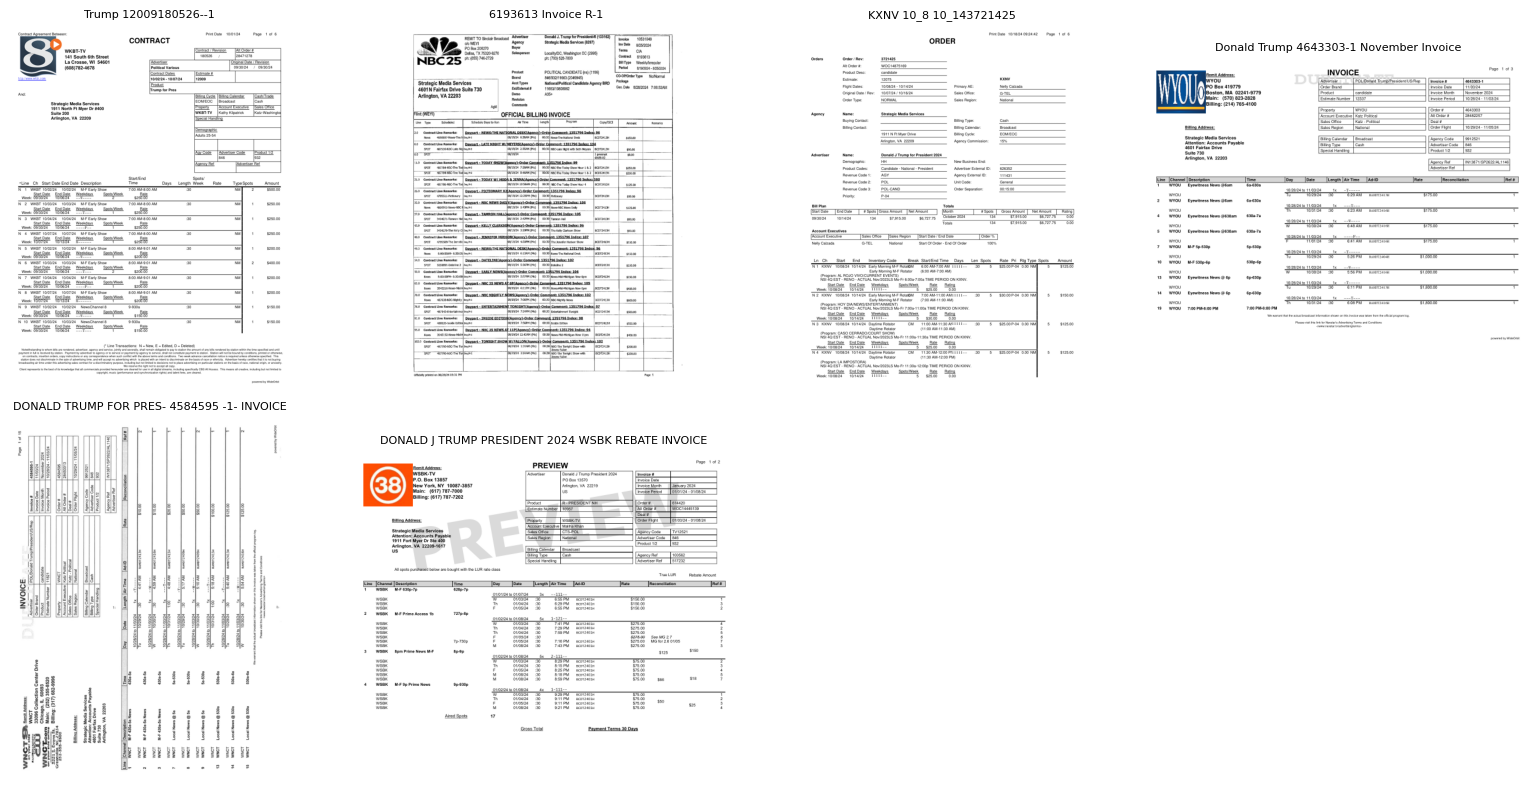

In [28]:
show_images(bucket_name, samples, n_cols = 4)

* as with classification using first-page image,the model spent the lowest amount of thought tokens and was mostly confident with 4 contracts that it mis-classified as invoices.  

* To be fair to the model, misclassified contracts are not your typical contracts with a lot of text with clauses; they do resemble invoices by their structure.

##### PRECISION AND RECALL (0.36; 0.94)

In [44]:
# img_pdf_pred: documents classified with both methods as True

pdf_pred = df.query("is_invoice==True & src=='pdf'",engine='python').file_id.unique()
print(f"Predicted by pdf: {len(pdf_pred)}")


# TP, FP, FN
TP = set(pdf_pred).intersection(set(true_file_ids))
print(f"TP: {len(TP)}")

FP = set(pdf_pred).difference(set(true_file_ids))
print(f"FP: {len(FP)}")

FN = set(true_file_ids).difference(pdf_pred)
print(f"FN: {len(FN)}")

TP_len = len(TP)
FP_len = len(FP)
FN_len = len(FN)

precision = TP_len / (TP_len + FP_len)
print(f"Precision: {precision: .2f}")

recall = TP_len / (TP_len + FN_len)
print(f"Recall: {recall: .2f}")

Predicted by pdf: 181
TP: 65
FP: 116
FN: 4
Precision:  0.36
Recall:  0.94


application of AI.GENERATE_BOOL function to the invoice classification using entire pdf files  resulted in:
* even lower precision (0.17 vs 0.25) than when we used first-page images

* a very low Recall of 0.53 (vs 0.89)

##### gemini costs

In [45]:
gemini_cost = df['usage_metadata'].apply(calculate_gemini_cost).sum()
print(f"Gemini cost: $ {gemini_cost: .6f}")

Gemini cost: $  0.000306


##### Backfill is_invoice_pdf Column
The PDF-based classification results are merged into the source table under the is_invoice_pdf column, enabling side-by-side comparison with image-based results.

In [ ]:
# 1) Add the target column if it doesn't exist
bq_client.query(f"""
ALTER TABLE `{SOURCE_TABLE}`
ADD COLUMN IF NOT EXISTS is_invoice_pdf BOOL
""").result()

# 2) Merge flags from the PDF classification table into the source
#    Assumes DEST_TABLE has columns: pdf_key, is_invoice
bq_client.query(f"""
MERGE `{SOURCE_TABLE}` T
USING `{DEST_TABLE}` R
ON T.pdf_key = R.pdf_key
WHEN MATCHED THEN
  UPDATE SET T.is_invoice_pdf = R.is_invoice
""").result()

print("✅ Backfilled is_invoice_pdf into:", SOURCE_TABLE)


✅ Backfilled is_invoice_pdf into: data-science-455302.trump_campaign_us_central1.TRUMP_PDF_FILES


##### initialize stats_df to store classification stats

In [54]:
stats_df = pd.DataFrame()

In [55]:
df['method'] = 'ai_bool'
df['src'] = 'pdf'
df['is_invoice_true'] = df['file_id'].apply(lambda x: True if x in true_file_ids else False).sum()
df.rename(columns={'pdf_key':'file_key',
                   'is_invoice':'is_invoice_pred'}, inplace=True)
stats_df = pd.concat([stats_df, df])
stats_df.shape

(298, 13)

##### save stats_df

In [56]:
buffer = BytesIO()
stats_df.to_parquet(buffer, engine="pyarrow", index=False)

# Upload to GCS
upload_bytesio_to_gcs(
    buffer,
    "gs://trump-political-ads-sample/metadata/stats_df.parquet",
    content_type="application/parquet"
)

✅ Uploaded buffer → gs://trump-political-ads-sample/metadata/stats_df.parquet


#### Classify All First-Page Images
This query runs invoice classification on all first-page images in the dataset. Using images greatly reduces token cost compared to PDFs, while still providing a good first-pass classification.

* in the notebook 0 we extarcted images of the first pages of the document files, stored them in a bucket and put links to those images into the column image_key of the BQ table.

* we will use those first-page images to classify the whole documents - we are going to save a lot of input tokens while not compromizing much on the accuracy, since it's usually easy to understand if a document is an invoice by looking at its very first page

In [ ]:
sql = f"""
CREATE OR REPLACE TABLE `{DEST_TABLE}` AS
WITH src AS (
  SELECT
    image_key,
    -- Convert to public HTTPS and URL-encode spaces
    REPLACE(
      REPLACE(image_key, 'gs://', 'https://storage.googleapis.com/'),
      ' ', '%20'
    ) AS url
  FROM `{SOURCE_TABLE}`
  WHERE image_key IS NOT NULL
    AND REGEXP_CONTAINS(LOWER(image_key), r'\\.(png|jpg|jpeg)$')
),
calls AS (
  SELECT
    image_key,
    AI.GENERATE_BOOL(
      ('Is this image an invoice? Answer strictly True or False.', url),
      connection_id => '{CONNECTION_RESOURCE}',
      endpoint      => '{model_endpoint}'
    ) AS r
  FROM src
)
SELECT
  image_key,
  r.result        AS is_invoice,
  r.status        AS status,
  r.full_response AS full_response
FROM calls
"""
bq_client.query(sql).result()
print("Created with full_response:", DEST_TABLE)


let's check results:

##### gather model output statistics

In [66]:
df = bq_client.query(f"""
SELECT * FROM `{DEST_TABLE}`
""").to_dataframe()
df.shape

(298, 4)

In [67]:
df['avg_logprobs'] = df['full_response'].apply(lambda x:
                                               json.loads(x)['candidates'][0]['avg_logprobs'])
df['prompt_token_count'] = df['full_response'].apply(lambda x:
                                        json.loads(x)['usage_metadata']['prompt_token_count'])
df['thoughts_token_count'] = df['full_response'].apply(lambda x:
                                        json.loads(x)['usage_metadata']['thoughts_token_count'])
df['usage_metadata'] = df['full_response'].apply(lambda x:
                                        json.loads(x)['usage_metadata'])

df['src'] = 'image'

df['file_id'] = df['image_key'].str.split('/').str[5]
df['file_name'] = df['image_key'].str.split('/').str[6]


##### distr of avg_logprobs

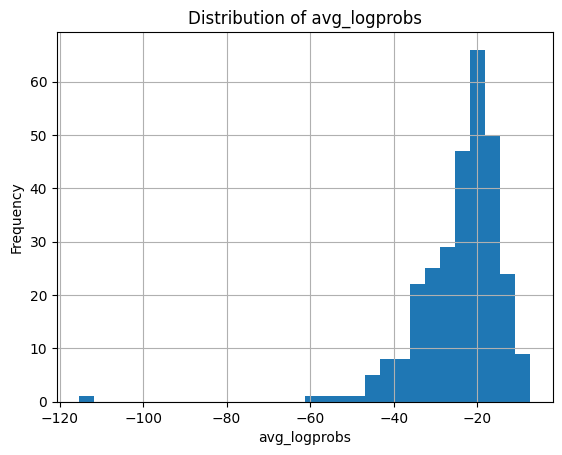

In [60]:
df['avg_logprobs'].hist(bins=30)
plt.xlabel("avg_logprobs")
plt.ylabel("Frequency")
plt.title("Distribution of avg_logprobs")
plt.show()

* Distribution of avg_logprobs shows that the model is not confident of its completion results: most avg_logprobs lie in the interval of `-15 to - 30`.  

* This is quite a surprising result for the seemingly simple document classification task

In [61]:
gemini_cost = df['usage_metadata'].apply(calculate_gemini_cost).sum()
print(f"Gemini cost: $ {gemini_cost: .6f}")

Gemini cost: $  0.000311


##### distribution of thoughts tokens

In [62]:
df['thoughts_token_count'].sum().item()

217870

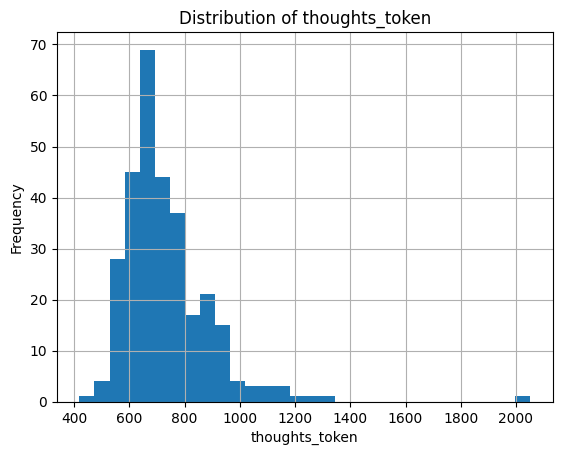

In [63]:
df['thoughts_token_count'].hist(bins=30)
plt.xlabel("thoughts_token")
plt.ylabel("Frequency")
plt.title("Distribution of thoughts_token")
plt.show()

let's see which documents were outliers in terms of the numbre of thought tokens

In [68]:
samples = df.query("thoughts_token_count > 1100").copy()
samples

image_key  is_invoice status  \
0    gs://trump-political-ads-sample/FCC/docs/44686...       False          
3    gs://trump-political-ads-sample/FCC/docs/20365...       False          
41   gs://trump-political-ads-sample/FCC/docs/de458...       False          
70   gs://trump-political-ads-sample/FCC/docs/135a8...       False          
71   gs://trump-political-ads-sample/FCC/docs/29676...       False          
227  gs://trump-political-ads-sample/FCC/docs/e40e8...        True          
262  gs://trump-political-ads-sample/FCC/docs/a1d7b...        True          
295  gs://trump-political-ads-sample/FCC/docs/7c414...        True          

                                         full_response  avg_logprobs  \
0    {"candidates":[{"avg_logprobs":-51.45156860351...    -51.451569   
3    {"candidates":[{"avg_logprobs":-48.97044067382...    -48.970441   
41   {"candidates":[{"avg_logprobs":-115.2564819335...   -115.256482   
70   {"candidates":[{"avg_logprobs":-46.41776123046...    -46.417761   
71   {"candidates":[{"avg_logprobs":-40.88516845703...    -40.885168   
227  {"candidates":[{"avg_logprobs":-59.71953125,"c...    -59.719531   
262  {"candidates":[{"avg_logprobs":-33.49182467990...    -33.491825   
295  {"candidates":[{"avg_logprobs":-56.39421997070...    -56.394220   

     prompt_token_count  thoughts_token_count  \
0                    83                  1155   
3                    88                  1253   
41                  105                  2052   
70                  128                  1123   
71                  136                  1146   
227                 112                  1295   
262                 124                  1214   
295                 173                  1131   

                                        usage_metadata    src  \
0    {'billable_prompt_usage': {'text_count': 180},...  image   
3    {'billable_prompt_usage': {'text_count': 198},...  image   
41   {'billable_prompt_usage': {'text_count': 231},...  image   
70   {'billable_prompt_usage': {'text_count': 240},...  image   
71   {'billable_prompt_usage': {'text_count': 259},...  image   
227  {'billable_prompt_usage': {'text_count': 230},...  image   
262  {'billable_prompt_usage': {'text_count': 231},...  image   
295  {'billable_prompt_usage': {'text_count': 297},...  image   

                                  file_id  \
0    44686740-5ce8-79de-72ad-3215ca69a0a1   
3    20365934-7c6a-b1bd-1be7-dcdebda22443   
41   de458f43-21a6-9243-69c8-dbc13ccbe7cc   
70   135a8038-a1b0-77b5-fc5d-82ee35aee869   
71   296760c1-8d7a-7604-cc94-82ca39251a43   
227  e40e874e-fba5-00ab-7fcc-709a7e7f7139   
262  a1d7b794-d7a3-6809-27f8-09fbe8e0cf23   
295  7c414ba8-2d9b-2996-7a47-945983c7edc7   

                                             file_name  
0                                           PL24090336  
3                               Trump General NAB 7.29  
41   283446-Donald J. Trump for President, Inc.-WUV...  
70   KTTU POL DONALD TRUMP_2967109_EST 11800_FLT 9....  
71   CONTRACT DONALD J TRUMP FOR PRESIDENT WRAZ EST...  
227   Donald J. Trump For President 1378733-5est 11615  
262  DONALD TRUMP WYDO EST 11814 6214928-9.10.24-9....  
295  WAXN - POL - D TRUMP - R - PRES - NAB CONTRACT...

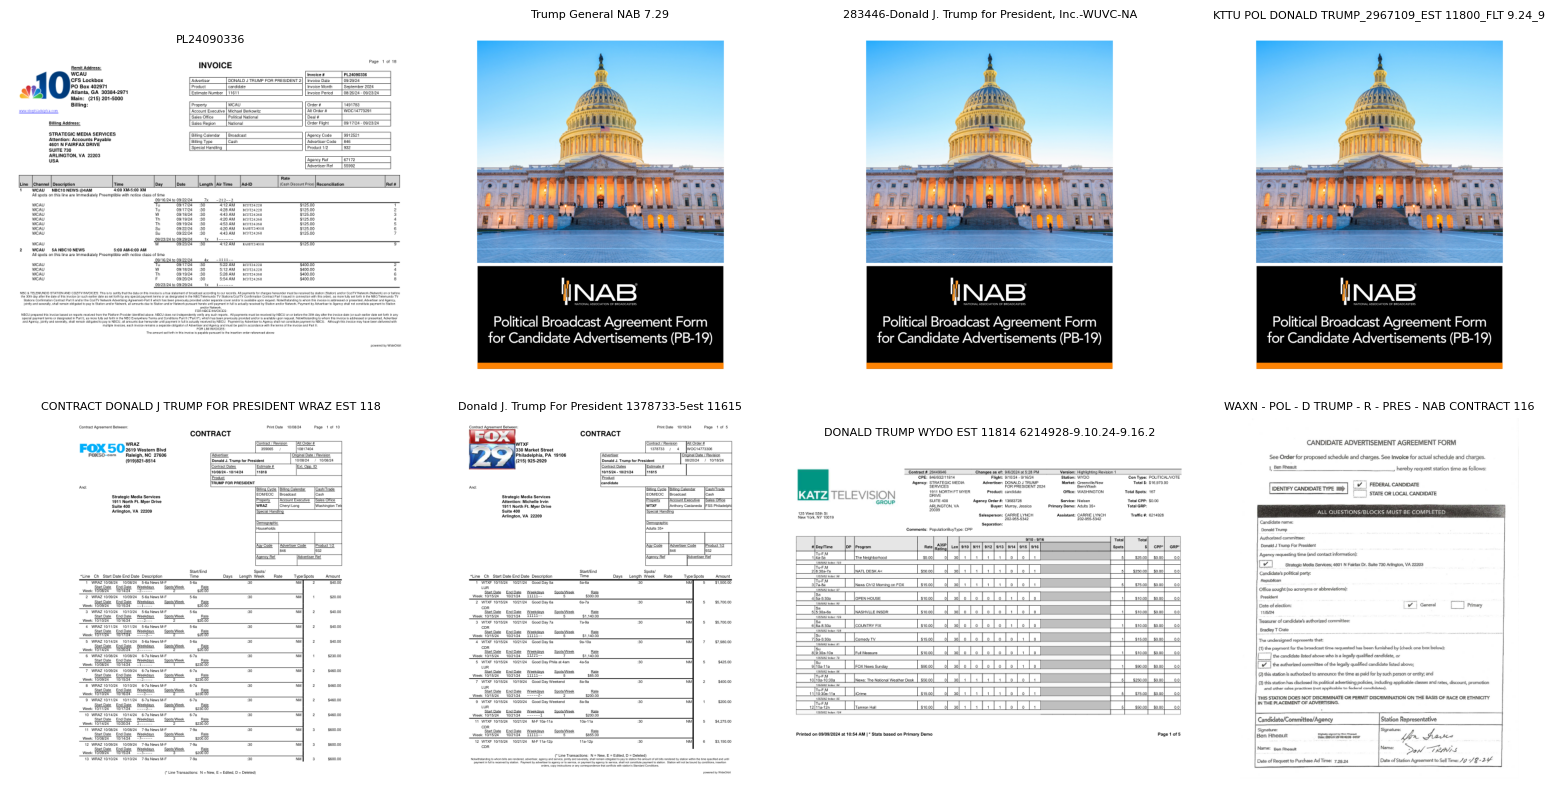

In [69]:
show_images(bucket_name, samples, n_cols = 4)

In [74]:
samples = df.query("thoughts_token_count <550 & avg_logprobs > -12")
# samples['file_name'] = samples['image_key'].apply(lambda x: x.split('/')[-2])
samples

image_key  is_invoice status  \
126  gs://trump-political-ads-sample/FCC/docs/aecdd...        True          
130  gs://trump-political-ads-sample/FCC/docs/48ff7...        True          
193  gs://trump-political-ads-sample/FCC/docs/f8d1f...        True          
231  gs://trump-political-ads-sample/FCC/docs/e8714...        True          

                                         full_response  avg_logprobs  \
126  {"candidates":[{"avg_logprobs":-11.62573750813...    -11.625738   
130  {"candidates":[{"avg_logprobs":-10.66961746215...    -10.669617   
193  {"candidates":[{"avg_logprobs":-7.940544976128...     -7.940545   
231  {"candidates":[{"avg_logprobs":-9.690712822808...     -9.690713   

     prompt_token_count  thoughts_token_count  \
126                  96                   539   
130                  97                   532   
193                 106                   544   
231                 114                   511   

                                        usage_metadata    src  \
126  {'billable_prompt_usage': {'text_count': 216},...  image   
130  {'billable_prompt_usage': {'text_count': 201},...  image   
193  {'billable_prompt_usage': {'text_count': 205},...  image   
231  {'billable_prompt_usage': {'text_count': 213},...  image   

                                  file_id                           file_name  
126  aecdd5e2-f5f8-9e4c-6dde-7309ff4a5ae4  Donald J Trump for President - NAB  
130  48ff7965-e456-a6a3-59d0-a4e9c47a3f4d           TRUMP R PRESIDENT 4110890  
193  f8d1f265-6b2a-d074-0d6f-2747c6a13c76       KSAZ Trump est11802 1382983-1  
231  e8714d02-1156-7226-46d2-32b6acda8d76   ELAJ DT 11810 4583730 1008-14 Rev

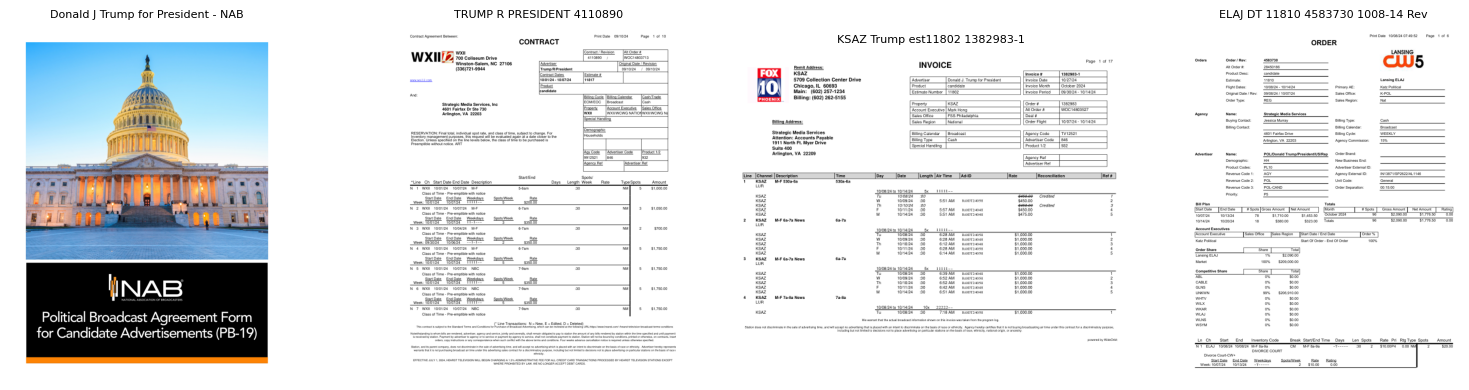

In [75]:
show_images(bucket_name, samples, n_cols = 4)

* the model spent the lowets amount of thought tokens and was mostly confident with 4 documents of which  1 was mis-classified while 3 were classified correctly.  

* To be fair to the model, misclassified document does resemble an invoice by its structure.

##### PRECISION AND RECALL (0.30; 0.99)

In [76]:
# img_pdf_pred: documents classified with both methods as True

pdf_pred = df.query("is_invoice==True & src=='image'",engine='python').file_id.unique()
print(f"Predicted by pdf: {len(pdf_pred)}")


# TP, FP, FN
TP = set(pdf_pred).intersection(set(true_file_ids))
print(f"TP: {len(TP)}")

FP = set(pdf_pred).difference(set(true_file_ids))
print(f"FP: {len(FP)}")

FN = set(true_file_ids).difference(pdf_pred)
print(f"FN: {len(FN)}")

TP_len = len(TP)
FP_len = len(FP)
FN_len = len(FN)

precision = TP_len / (TP_len + FP_len)
print(f"Precision: {precision: .2f}")

recall = TP_len / (TP_len + FN_len)
print(f"Recall: {recall: .2f}")

Predicted by pdf: 225
TP: 68
FP: 157
FN: 1
Precision:  0.30
Recall:  0.99


application of AI.GENERATE_BOOL function to the invoice classification task resulted in:
* a very low precision (0.25) - due to many false positives  

* a modest Recall of 0.89

##### gemini costs

In [ ]:
gemini_cost = df['usage_metadata'].apply(calculate_gemini_cost).sum()
print(f"Gemini cost: $ {gemini_cost: .6f}")

Gemini cost: $  0.000310


##### Backfill is_invoice_img Column
The results from the image-based classification table are merged back into the source table so that each record now carries its invoice flag (is_invoice_img).$

In [ ]:
# 1) Add the target column if it doesn't exist
bq_client.query(f"""
ALTER TABLE `{SOURCE_TABLE}`
ADD COLUMN IF NOT EXISTS is_invoice_img BOOL
""").result()

# 2) Merge flags from the right-hand table
bq_client.query(f"""
MERGE `{SOURCE_TABLE}` T
USING `{DEST_TABLE}` R
ON T.image_key = R.image_key
WHEN MATCHED THEN
  UPDATE SET T.is_invoice_img = R.is_invoice
""").result()

print("✅ Backfilled is_invoice_img into:", SOURCE_TABLE)



✅ Backfilled is_invoice_img into: data-science-455302.trump_campaign_us_central1.TRUMP_PDF_FILES


In [81]:
df['method'] = 'ai_bool'
df['src'] = 'image'
df.rename(columns={'image_key':'file_key',
                   'is_invoice':'is_invoice_pred'}, inplace=True)
df['is_invoice_true'] = df['file_id'].apply(lambda x: True if x in true_file_ids else False)



In [84]:
stats_df = pd.concat([stats_df, df],ignore_index=True)
stats_df.shape

(596, 13)

##### save stats_df

we will add field `is_invoice_truth` before saving

In [114]:
buffer = BytesIO()
stats_df.to_parquet(buffer, engine="pyarrow", index=False)

# Upload to GCS
upload_bytesio_to_gcs(
    buffer,
    "gs://trump-political-ads-sample/metadata/stats_df.parquet",
    content_type="application/parquet"
)

✅ Uploaded buffer → gs://trump-political-ads-sample/metadata/stats_df.parquet


#### Analyze Overlap Between Image and PDF Results
This query compares records classified as invoices by both methods, helping us evaluate agreement and identify false positives or negatives.

let's compare results of the 2 approaches to the document classification task:
* using first page image
* usuing the entire pdf file

In [86]:
# load stats_df if needed
uri = "gs://trump-political-ads-sample/metadata/stats_df.parquet"
stats_df = pd.read_parquet(uri)
stats_df.shape

(596, 13)

In [87]:
stats_df.sample(5)

file_key  is_invoice_pred  \
287  gs://trump-political-ads-sample/FCC/docs/cc1f4...             True   
375  gs://trump-political-ads-sample/FCC/docs/8f989...             True   
231  gs://trump-political-ads-sample/FCC/docs/68382...             True   
247  gs://trump-political-ads-sample/FCC/docs/8cad4...             True   
106  gs://trump-political-ads-sample/FCC/docs/2d72d...            False   

    status                                      full_response  avg_logprobs  \
287         {"candidates":[{"avg_logprobs":-16.92149505615...    -16.921495   
375         {"candidates":[{"avg_logprobs":-31.13209533691...    -31.132095   
231         {"candidates":[{"avg_logprobs":-27.16213989257...    -27.162140   
247         {"candidates":[{"avg_logprobs":-11.44802178276...    -11.448022   
106         {"candidates":[{"avg_logprobs":-29.79827880859...    -29.798279   

     prompt_token_count  thoughts_token_count  \
287                 148                   585   
375                  88                   783   
231                 101                   791   
247                 107                   637   
106                 117                   843   

                                        usage_metadata    src  \
287  {'billable_prompt_usage': {'text_count': 266},...    pdf   
375  {'billable_prompt_usage': {'text_count': 202},...  image   
231  {'billable_prompt_usage': {'text_count': 225},...    pdf   
247  {'billable_prompt_usage': {'text_count': 233},...    pdf   
106  {'billable_prompt_usage': {'text_count': 255},...    pdf   

                                  file_id  \
287  cc1f40e6-884a-c531-57a4-2a2d9d92dd7b   
375  8f989864-7bf0-3633-4c73-59cf865de0ef   
231  68382e11-456f-e35d-1093-f8bad5d40cce   
247  8cad477e-bae1-49f2-de5e-4dd17e5d70dc   
106  2d72da53-993c-3374-85df-71b8e40acc44   

                                             file_name   method  \
287  DONALD J. TRUMP - WXLV - EST 11821 - 28450238 ...  ai_bool   
375                         Trump General NAB (Signed)  ai_bool   
231    271601-Donald Trump for President- WUVG-ATLANTA  ai_bool   
247  97275-1 Donald J Trump for President 2024 Invoice  ai_bool   
106  Donald J. Trump for President confirmation con...  ai_bool   

     is_invoice_true  
287               69  
375               69  
231               69  
247               69  
106               69

##### PRECISION AND RECALL

In [89]:
# img_pdf_pred: documents classified with both methods as True

pdf_pred = stats_df.query("is_invoice_pred==True & src=='pdf'",engine='python').file_id.unique()
print(f"Predicted by pdf: {len(pdf_pred)}")

img_pred = stats_df.query("is_invoice_pred==True & src=='image'", engine="python").file_id.unique()
print(f"Predicted by image: {len(img_pred)}")

img_pdf_pred = set(img_pred).intersection(set(pdf_pred))
print(f"Predicted by both pdf and image: {len(img_pdf_pred)}")

# TP, FP, FN
TP = img_pdf_pred.intersection(set(true_file_ids))
print(f"TP: {len(TP)}")

FP = img_pdf_pred.difference(set(true_file_ids))
print(f"FP: {len(FP)}")

FN = set(true_file_ids).difference(img_pdf_pred)
print(f"FN: {len(FN)}")

TP_len = len(TP)
FP_len = len(FP)
FN_len = len(FN)

precision = TP_len / (TP_len + FP_len)
print(f"Precision: {precision: .2f}")

recall = TP_len / (TP_len + FN_len)
print(f"Recall: {recall: .2f}")

Predicted by pdf: 181
Predicted by image: 225
Predicted by both pdf and image: 158
TP: 64
FP: 94
FN: 5
Precision:  0.41
Recall:  0.93


by applying AI.GENERATE_BOOL method to both pdf files and first page omages we:

* usually increase Precision

* Recall  sometimes improves, sometimes goes down a little bit

* However, precision with classification using AI.GENERATE_BOOL on pdfs and images is always quite low

* let's see if we can imporve this metrics by applying AI.GENERATE method

##### Visualization of False Positives

In [90]:
pdf_pred = list(pdf_pred)
img_pred = list(img_pred)
img_pdf_pred = list(img_pdf_pred)
file_ids_true = list(true_file_ids)
FP = list(FP)

(94, 8)


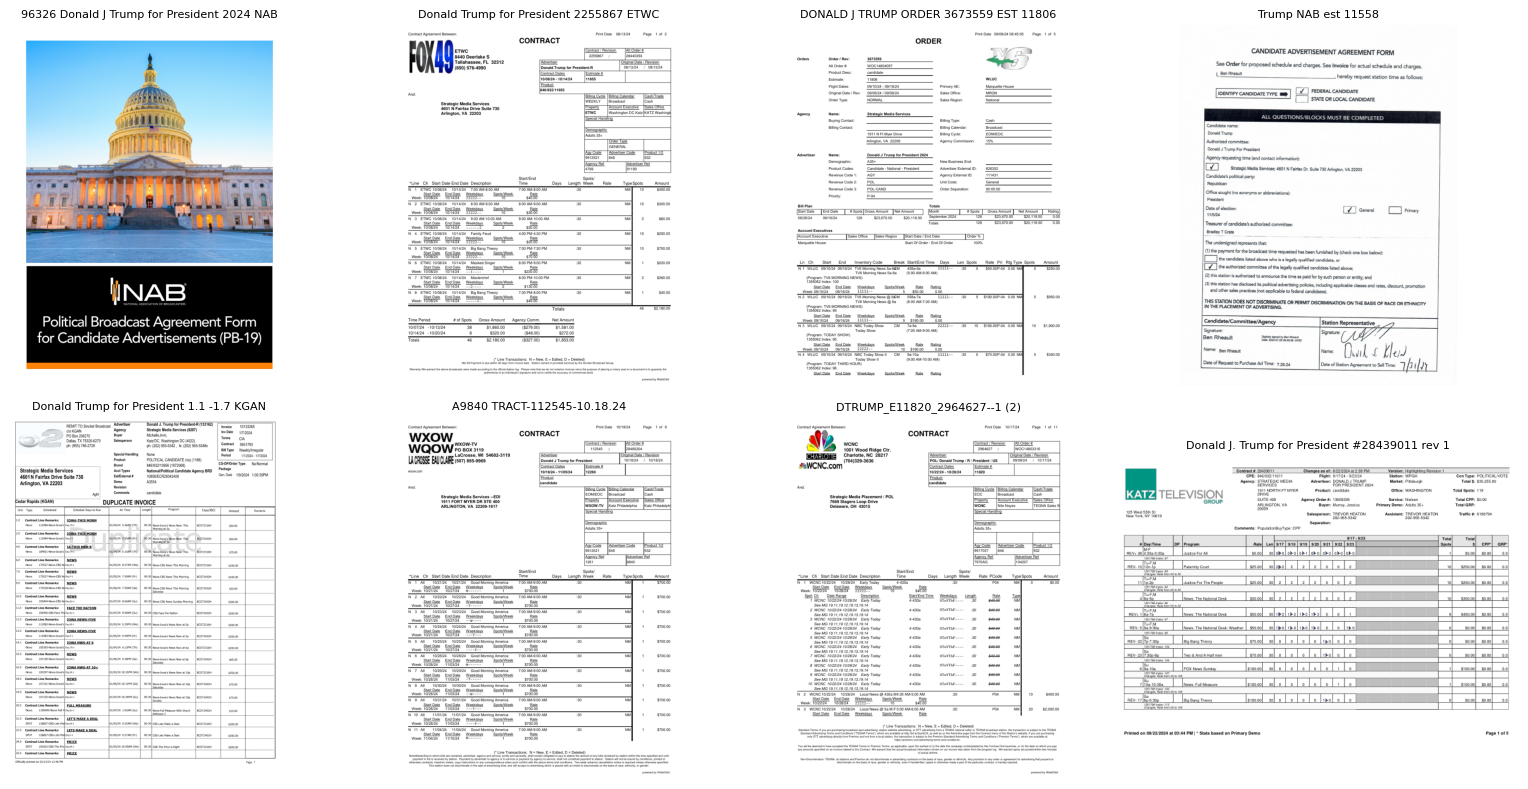

In [91]:
fp_df = table_df.query("file_id==@FP")
print(fp_df.shape)
samples = fp_df.sample(8)
show_images(bucket_name, samples)

## Step 2. Invoice Classification: AI.GENERATE

* let's change the approach: we are going to use AI.GENERATE method;  

* we will construct a prompt to classify out files as one of ['invoice','contract','order', 'other'].

* we will work with only those files that were classified as 'is_invoice'= True by the AI.GENERATE_BOOL function, but have no 'inv|invoice' hint in the file name.

* out goal here is to use AI.GENERATE function to identify file documents which were incorrectly classified as 'invoice' ('is_invoice'=True) by the AI.GENERATE_BOOL function

### classification_prompt and schema_json

In [93]:
# Prompt + schema
CLASSIFICATION_PROMPT = """
You are a document classification model.
Carefully read the provided document (it may be a PDF or an image of a PDF page).
Classify it strictly into one of the following categories:
- "invoice": a billing document that requests payment, typically includes amounts due, invoice numbers, dates, line items, and totals. It usually is entitled "Invoice" at the top of the first page
- "contract": a legal agreement between parties, often with clauses, obligations, terms, and signatures. It usually is entitled "Contract" at the top of the first page
- "order": a purchase order or media order, often showing ordered items, placements, or services to be delivered, but not an actual invoice. It usually is entitled "Order" at the top of the first page
- "other": any document that does not clearly fit into the above three categories (e.g., disclosures, receipts, letters, media plans).
Return the result only as a valid JSON object with the following structure:
{"class": "<one of: invoice, contract, order, other>"}
""".strip()

SCHEMA_JSON = json.dumps({
    "type": "object",
    "properties": {
        "class": {"type": "string", "enum": ["invoice", "contract", "order", "other"]}
    },
    "required": ["class"]
})


### all rows classification using AI.GENERATE function



#### Classify all PDF files

In [94]:
DEST_TABLE   = f"{PROJECT_ID}.{DATASET_ID}.TRUMP_IMAGE_FLAGS"
MODEL_ENDPOINT = 'gemini-2.5-pro'

# Classify PDFs (pdf_key) into {"class": "..."} and save to DEST_TABLE
sql = f"""
CREATE OR REPLACE TABLE `{DEST_TABLE}` AS
WITH src AS (
  SELECT
    pdf_key,
    REPLACE(REPLACE(pdf_key, 'gs://', 'https://storage.googleapis.com/'), ' ', '%20') AS url
  FROM `{SOURCE_TABLE}`
  WHERE pdf_key IS NOT NULL
    AND REGEXP_CONTAINS(LOWER(pdf_key), r'\\.pdf$')
),
calls AS (
  SELECT
    pdf_key,
    AI.GENERATE(
      STRUCT(@prompt AS prompt, url AS input, @schema AS schema),
      connection_id => '{CONNECTION_RESOURCE}',
      endpoint      => '{MODEL_ENDPOINT}'
    ) AS response
  FROM src
),
parsed AS (
  SELECT
    pdf_key,
    response.result        AS json_result,
    JSON_VALUE(response.result, '$.class') AS class,
    response.full_response AS raw_response
  FROM calls
)
SELECT
  pdf_key,
  class,
  json_result,
  raw_response
FROM parsed
"""

job_cfg = bigquery.QueryJobConfig(
    query_parameters=[
        bigquery.ScalarQueryParameter("prompt", "STRING", CLASSIFICATION_PROMPT),
        bigquery.ScalarQueryParameter("schema", "STRING", SCHEMA_JSON),
    ]
)

bq_client.query(sql, job_config=job_cfg, location=REGION).result()
print("✅ Created:", DEST_TABLE)



✅ Created: data-science-455302.trump_campaign_us_central1.TRUMP_IMAGE_FLAGS


let's clean json_result in the DEST_TABLE

In [95]:
bq_client.query(f"""
UPDATE `{DEST_TABLE}`
SET class = COALESCE(
  JSON_VALUE(
    TRIM(
      REGEXP_REPLACE(
        REGEXP_REPLACE(json_result, r'```\\s*json\\s*', ''),
        r'```', ''
      )
    ),
    '$.class'
  ),
  REGEXP_EXTRACT(
    TRIM(
      REGEXP_REPLACE(
        REGEXP_REPLACE(json_result, r'```\\s*json\\s*', ''),
        r'```', ''
      )
    ),
    r'"class"\\s*:\\s*"(invoice|contract|order|other)"'
  )
)
WHERE class IS NULL
  AND json_result IS NOT NULL
""", location=REGION).result()

In [ ]:
# 1) Add the column if it doesn't exist
add_col_sql = f"""
ALTER TABLE `{SOURCE_TABLE}`
ADD COLUMN IF NOT EXISTS doc_class_pdf STRING
"""
bq_client.query(add_col_sql, location=REGION).result()
print("✅ Column 'doc_class_pdf' ensured in SOURCE_TABLE")

# 2) Merge values from DEST_TABLE.class into SOURCE_TABLE.doc_class_pdf
merge_sql = f"""
MERGE `{SOURCE_TABLE}` T
USING `{DEST_TABLE}` D
ON T.pdf_key = D.pdf_key
WHEN MATCHED AND D.class IS NOT NULL THEN
  UPDATE SET T.doc_class_pdf = D.class
"""
bq_client.query(merge_sql, location=REGION).result()
print("✅ Backfilled SOURCE_TABLE.doc_class_pdf from DEST_TABLE.class")


✅ Column 'doc_class_pdf' ensured in SOURCE_TABLE
✅ Backfilled SOURCE_TABLE.doc_class_pdf from DEST_TABLE.class


##### gather model output statistics

In [96]:
df = bq_client.query(f"""
SELECT * FROM `{DEST_TABLE}`
""").to_dataframe()
df.shape

(298, 4)

In [97]:
df['avg_logprobs'] = df['raw_response'].apply(lambda x:
                                               json.loads(x)['candidates'][0]['avg_logprobs'])
df['prompt_token_count'] = df['raw_response'].apply(lambda x:
                                        json.loads(x)['usage_metadata']['prompt_token_count'])
df['thoughts_token_count'] = df['raw_response'].apply(lambda x:
                                        json.loads(x)['usage_metadata']['thoughts_token_count'])
df['usage_metadata'] = df['raw_response'].apply(lambda x:
                                        json.loads(x)['usage_metadata'])

df['src'] = 'pdf'

df['file_id'] = df['pdf_key'].str.split('/').str[5]
df['file_name'] = df['pdf_key'].str.split('/').str[6]

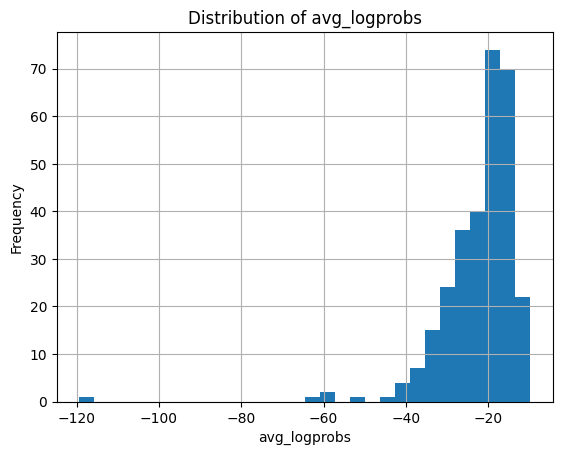

In [98]:
df['avg_logprobs'].hist(bins=30)
plt.xlabel("avg_logprobs")
plt.ylabel("Frequency")
plt.title("Distribution of avg_logprobs")
plt.show()

##### distribution of thoughts tokens

In [99]:
df['thoughts_token_count'].sum().item()

361169

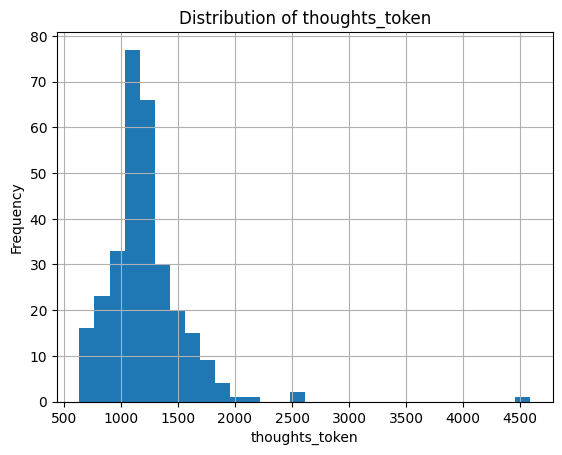

In [100]:
df['thoughts_token_count'].hist(bins=30)
plt.xlabel("thoughts_token")
plt.ylabel("Frequency")
plt.title("Distribution of thoughts_token")
plt.show()

let's see which documents were outliers in terms of the number of thought tokens

##### most difficult pdf files

In [101]:
samples = df.query("thoughts_token_count >2000 & avg_logprobs < -45").copy()
samples['file_name'] = samples['pdf_key'].apply(lambda x: x.split('/')[-2])
samples['image_key'] = samples['pdf_key'].apply(lambda x: x.replace('doc.pdf','page_1.png'))
samples

pdf_key    class  \
64   gs://trump-political-ads-sample/FCC/docs/81ba4...  invoice   
148  gs://trump-political-ads-sample/FCC/docs/bbe3e...  invoice   
213  gs://trump-political-ads-sample/FCC/docs/42b00...    order   
246  gs://trump-political-ads-sample/FCC/docs/f8d1f...    order   

                            json_result  \
64   ```json\n{"class": "invoice"}\n```   
148  ```json\n{"class": "invoice"}\n```   
213    ```json\n{"class": "order"}\n```   
246    ```json\n{"class": "order"}\n```   

                                          raw_response  avg_logprobs  \
64   {"candidates":[{"avg_logprobs":-59.56928045099...    -59.569280   
148  {"candidates":[{"avg_logprobs":-119.3342618075...   -119.334262   
213  {"candidates":[{"avg_logprobs":-58.01124711470...    -58.011247   
246  {"candidates":[{"avg_logprobs":-62.59802800958...    -62.598028   

     prompt_token_count  thoughts_token_count  \
64                  344                  2553   
148                 371                  4589   
213                 397                  2150   
246                 354                  2610   

                                        usage_metadata  src  \
64   {'billable_prompt_usage': {'text_count': 1121}...  pdf   
148  {'billable_prompt_usage': {'text_count': 1163}...  pdf   
213  {'billable_prompt_usage': {'text_count': 1185}...  pdf   
246  {'billable_prompt_usage': {'text_count': 1122}...  pdf   

                                  file_id  \
64   81ba4cbc-b368-6c7f-2150-eed5f0e8c1b6   
148  bbe3eb63-f3ad-a736-8b11-c41abc72d96d   
213  42b00151-178b-4ecb-c8af-b6695a125ef4   
246  f8d1f265-6b2a-d074-0d6f-2747c6a13c76   

                                             file_name  \
64                          Donald Trump 4556976 Rev 3   
148  Trump - R - President - WPTZ - 01-02-2024 - RE...   
213  Donald J. Trump for President C4561215 10-29-2...   
246                      KSAZ Trump est11802 1382983-1   

                                             image_key  
64   gs://trump-political-ads-sample/FCC/docs/81ba4...  
148  gs://trump-political-ads-sample/FCC/docs/bbe3e...  
213  gs://trump-political-ads-sample/FCC/docs/42b00...  
246  gs://trump-political-ads-sample/FCC/docs/f8d1f...

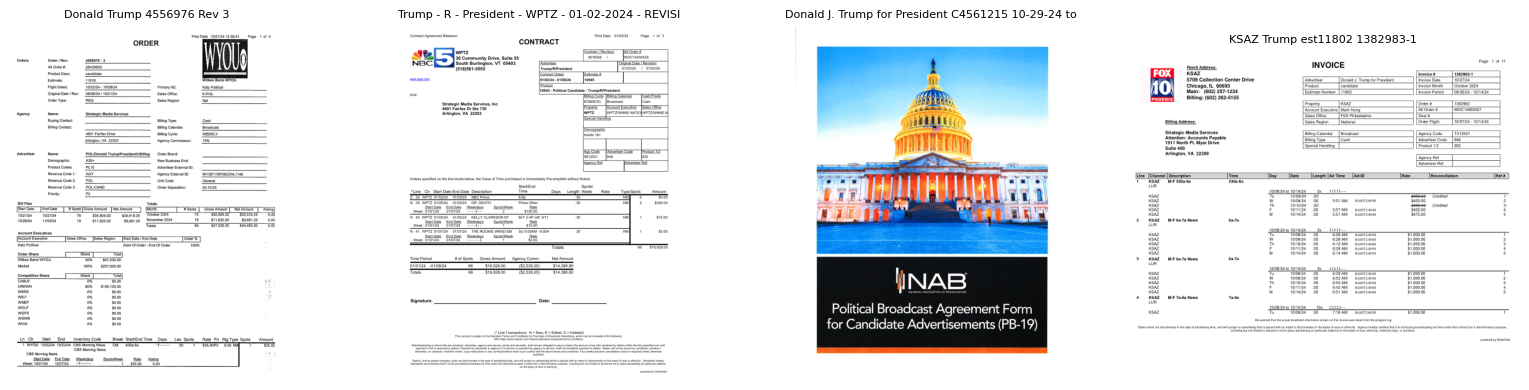

In [102]:
show_images(bucket_name, samples)

##### easiest pdf files

In [103]:
samples = df.query("thoughts_token_count <700 & avg_logprobs > -13").copy()
samples['file_name'] = samples['pdf_key'].apply(lambda x: x.split('/')[-2])
samples['image_key'] = samples['pdf_key'].apply(lambda x: x.replace('doc.pdf','page_1.png'))
samples

pdf_key    class  \
42   gs://trump-political-ads-sample/FCC/docs/9175d...  invoice   
123  gs://trump-political-ads-sample/FCC/docs/13f70...  invoice   
169  gs://trump-political-ads-sample/FCC/docs/28e2e...  invoice   
250  gs://trump-political-ads-sample/FCC/docs/eee8b...    order   

                            json_result  \
42   ```json\n{"class": "invoice"}\n```   
123  ```json\n{"class": "invoice"}\n```   
169  ```json\n{"class": "invoice"}\n```   
250    ```json\n{"class": "order"}\n```   

                                          raw_response  avg_logprobs  \
42   {"candidates":[{"avg_logprobs":-11.83359874378...    -11.833599   
123  {"candidates":[{"avg_logprobs":-12.39422329989...    -12.394223   
169  {"candidates":[{"avg_logprobs":-11.52579983797...    -11.525800   
250  {"candidates":[{"avg_logprobs":-9.951680963689...     -9.951681   

     prompt_token_count  thoughts_token_count  \
42                  341                   660   
123                 340                   697   
169                 394                   637   
250                 369                   657   

                                        usage_metadata  src  \
42   {'billable_prompt_usage': {'text_count': 1110}...  pdf   
123  {'billable_prompt_usage': {'text_count': 1109}...  pdf   
169  {'billable_prompt_usage': {'text_count': 1186}...  pdf   
250  {'billable_prompt_usage': {'text_count': 1155}...  pdf   

                                  file_id  \
42   9175d537-299d-d95f-a563-458ded772668   
123  13f70763-ec76-8496-c5e2-c5509f977181   
169  28e2e8d1-68e9-5c74-48a9-131293544294   
250  eee8b1b7-44a3-69db-5ed0-a29c0984ef69   

                                             file_name  \
42                                 6267988 Invoice R-2   
123                                   Trump - ACC 10.5   
169  WMSN Donald Trump for President EST 12260 Peri...   
250  Trump for President Est. 11733 9.3 thru 9.9.24...   

                                             image_key  
42   gs://trump-political-ads-sample/FCC/docs/9175d...  
123  gs://trump-political-ads-sample/FCC/docs/13f70...  
169  gs://trump-political-ads-sample/FCC/docs/28e2e...  
250  gs://trump-political-ads-sample/FCC/docs/eee8b...

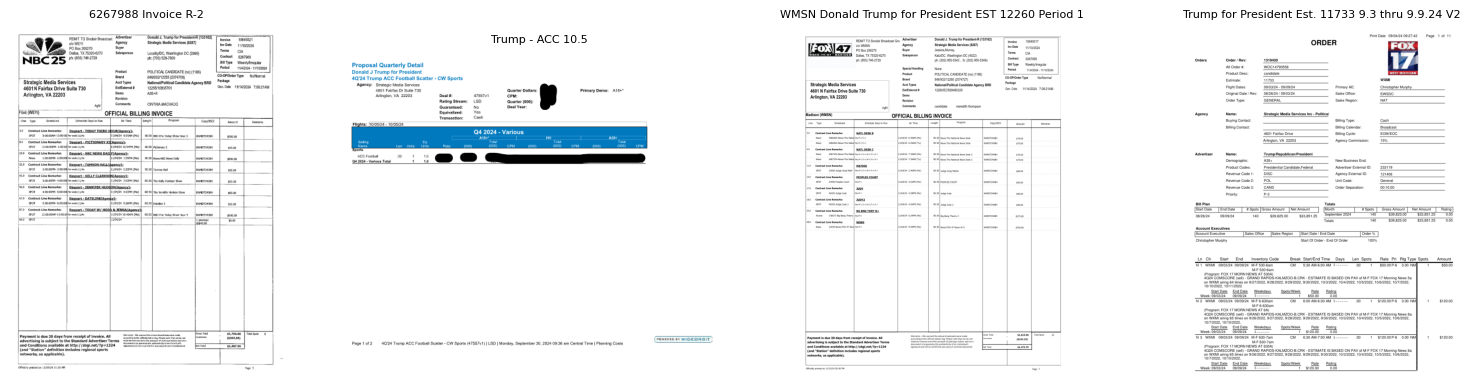

In [104]:
show_images(bucket_name, samples)

* among the 4 documents that the model spent less thought tokens on and assigned highest avg_probs, 2 were missclassified as invoices. They do resemble invoices, though, by their structure.

##### PRECISION AND RECALL

In [105]:
df['is_invoice_pred'] = df['json_result'].str.split('\n').str[1].apply(lambda x:
                                                                      json.loads(x)['class'])
df['is_invoice_pred'] = df['is_invoice_pred'].apply(lambda x: True if
                                                              x=='invoice' else False)
df['file_id'] = df['pdf_key'].str.split('/').str[5]

df['is_invoice_true'] = df['file_id'].apply(lambda x: True if x in true_file_ids else False)

df.drop(['class', 'json_result', 'raw_response'],axis=1,inplace=True)

In [106]:
file_ids_pred = df.query("is_invoice_pred==True").file_id.unique()
file_ids_pred = list(file_ids_pred)

TP = set(file_ids_pred).intersection(set(true_file_ids))
print(f"TP: {len(TP)}")

FP = set(file_ids_pred).difference(set(true_file_ids))
print(f"FP: {len(FP)}")

FN = set(file_ids_true).difference(set(file_ids_pred))
print(f"FN: {len(FN)}")

TP_len = len(TP)
FP_len = len(FP)
FN_len = len(FN)

precision = TP_len / (TP_len + FP_len)
print(f"Precision: {precision: .2f}")

recall = TP_len / (TP_len + FN_len)
print(f"Recall: {recall: .2f}")

TP: 66
FP: 84
FN: 3
Precision:  0.44
Recall:  0.96


application of AI.GENERATE function to the invoice classification using entire pdf files  resulted in:
* relatively high precision 0.46 vs 0.17 and 0.25 (AI.GENERATE_BOOL)

* relatively high recall of 0.96

In [109]:
df['method'] = 'ai_gen'
df['src'] = 'pdf'
df.rename(columns={'pdf_key':'file_key'},inplace=True)
df['is_invoice_true'] = df['file_id'].apply(lambda x: True if x in true_file_ids else False)

In [110]:
set(stats_df.columns) - set(df.columns)

{'full_response', 'status'}

In [111]:

stats_df = pd.concat([stats_df, df])
stats_df.shape

(894, 14)

In [121]:
buffer = BytesIO()
stats_df.to_parquet(buffer, engine="pyarrow", index=False)

# Upload to GCS
upload_bytesio_to_gcs(
    buffer,
    "gs://trump-political-ads-sample/metadata/stats_df.parquet",
    content_type="application/parquet"
)

✅ Uploaded buffer → gs://trump-political-ads-sample/metadata/stats_df.parquet



#### Classify All First-Page Images

In [122]:
sql = f"""
CREATE OR REPLACE TABLE `{DEST_TABLE}` AS
WITH src AS (
  SELECT
    image_key,
    REPLACE(REPLACE(image_key, 'gs://', 'https://storage.googleapis.com/'), ' ', '%20') AS url
  FROM `{SOURCE_TABLE}`
  WHERE image_key IS NOT NULL
    AND REGEXP_CONTAINS(LOWER(image_key), r'\\.(png|jpg|jpeg)$')
),
calls AS (
  SELECT
    image_key,
    AI.GENERATE(
      STRUCT(@prompt AS prompt, url AS input, @schema AS schema),
      connection_id => '{CONNECTION_RESOURCE}',
      endpoint      => '{MODEL_ENDPOINT}'
    ) AS response
  FROM src
),
parsed AS (
  SELECT
    image_key,
    response.result        AS json_result,
    JSON_VALUE(response.result, '$.class') AS class,
    response.full_response AS raw_response
  FROM calls
)
SELECT
  image_key,
  class,
  json_result,
  raw_response
FROM parsed
"""


job_cfg = bigquery.QueryJobConfig(
    query_parameters=[
        bigquery.ScalarQueryParameter("prompt", "STRING", CLASSIFICATION_PROMPT),
        bigquery.ScalarQueryParameter("schema", "STRING", SCHEMA_JSON),
    ]
)

bq_client.query(sql, job_config=job_cfg, location=REGION).result()
print("✅ Created:", DEST_TABLE)

✅ Created: data-science-455302.trump_campaign_us_central1.TRUMP_IMAGE_FLAGS


In [123]:
bq_client.query(f"""
UPDATE `{DEST_TABLE}`
SET class = COALESCE(
  JSON_VALUE(
    TRIM(
      REGEXP_REPLACE(
        REGEXP_REPLACE(json_result, r'```\\s*json\\s*', ''),
        r'```', ''
      )
    ),
    '$.class'
  ),
  REGEXP_EXTRACT(
    TRIM(
      REGEXP_REPLACE(
        REGEXP_REPLACE(json_result, r'```\\s*json\\s*', ''),
        r'```', ''
      )
    ),
    r'"class"\\s*:\\s*"(invoice|contract|order|other)"'
  )
)
WHERE class IS NULL
  AND json_result IS NOT NULL
""", location=REGION).result()

In [ ]:
# 1) Add the column if it doesn't exist
add_col_sql = f"""
ALTER TABLE `{SOURCE_TABLE}`
ADD COLUMN IF NOT EXISTS doc_class_img STRING
"""
bq_client.query(add_col_sql, location=REGION).result()
print("✅ Column 'doc_class_img' ensured in SOURCE_TABLE")

# 2) Merge values from DEST_TABLE.class into SOURCE_TABLE.doc_class_img
merge_sql = f"""
MERGE `{SOURCE_TABLE}` T
USING `{DEST_TABLE}` D
ON T.image_key = D.image_key
WHEN MATCHED THEN
  UPDATE SET T.doc_class_img = D.class
"""
bq_client.query(merge_sql, location=REGION).result()
print("✅ Backfilled SOURCE_TABLE.doc_class_img from DEST_TABLE.class")

✅ Column 'doc_class_img' ensured in SOURCE_TABLE
✅ Backfilled SOURCE_TABLE.doc_class_img from DEST_TABLE.class


##### gather model output statistics

In [124]:
df = bq_client.query(f"""
SELECT * FROM `{DEST_TABLE}`
""").to_dataframe()
df.shape

(298, 4)

In [125]:
df['avg_logprobs'] = df['raw_response'].apply(lambda x:
                                               json.loads(x)['candidates'][0]['avg_logprobs'])
df['prompt_token_count'] = df['raw_response'].apply(lambda x:
                                        json.loads(x)['usage_metadata']['prompt_token_count'])
df['thoughts_token_count'] = df['raw_response'].apply(lambda x:
                                        json.loads(x)['usage_metadata']['thoughts_token_count'])
df['usage_metadata'] = df['raw_response'].apply(lambda x:
                                        json.loads(x)['usage_metadata'])

df['src'] = 'image'

df['file_id'] = df['image_key'].str.split('/').str[5]
df['file_name'] = df['image_key'].str.split('/').str[6]

##### distr of avg_logprobs

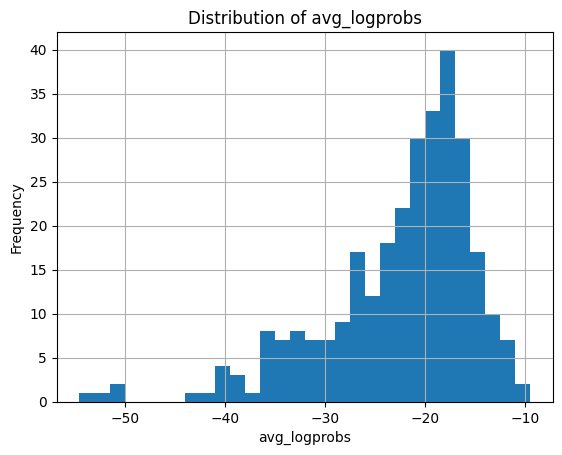

In [126]:
df['avg_logprobs'].hist(bins=30)
plt.xlabel("avg_logprobs")
plt.ylabel("Frequency")
plt.title("Distribution of avg_logprobs")
plt.show()

* Distribution of avg_logprobs shows that the model is not confident of its completion results: most avg_logprobs lie in the interval of `-15 to - 40`. the model is slightly more unconfident about its results as when it used first-page image (`-15 to -30`). And the level of confidence is again very low.

* As with the classification using images, this is quite a surprising result for the seemingly simple document classification task

##### distribution of thoughts tokens

In [127]:
df['thoughts_token_count'].sum().item()

371710

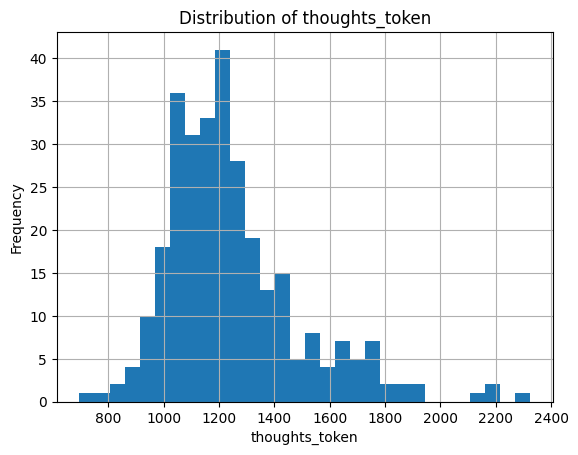

In [128]:
df['thoughts_token_count'].hist(bins=30)
plt.xlabel("thoughts_token")
plt.ylabel("Frequency")
plt.title("Distribution of thoughts_token")
plt.show()

##### most difficult image files

In [130]:
samples = df.query("thoughts_token_count >2000 & avg_logprobs < -40").copy()
samples['file_name'] = samples['image_key'].apply(lambda x: x.split('/')[-2])
samples

image_key    class  \
2    gs://trump-political-ads-sample/FCC/docs/1121a...    order   
78   gs://trump-political-ads-sample/FCC/docs/d684f...    order   
229  gs://trump-political-ads-sample/FCC/docs/fc999...  invoice   
230  gs://trump-political-ads-sample/FCC/docs/a9c19...    order   

                            json_result  \
2      ```json\n{"class": "order"}\n```   
78     ```json\n{"class": "order"}\n```   
229  ```json\n{"class": "invoice"}\n```   
230    ```json\n{"class": "order"}\n```   

                                          raw_response  avg_logprobs  \
2    {"candidates":[{"avg_logprobs":-51.84428821910...    -51.844288   
78   {"candidates":[{"avg_logprobs":-50.70907315340...    -50.709073   
229  {"candidates":[{"avg_logprobs":-54.55085893110...    -54.550859   
230  {"candidates":[{"avg_logprobs":-51.17055996981...    -51.170560   

     prompt_token_count  thoughts_token_count  \
2                   335                  2325   
78                  346                  2193   
229                 367                  2213   
230                 367                  2134   

                                        usage_metadata    src  \
2    {'billable_prompt_usage': {'text_count': 1101}...  image   
78   {'billable_prompt_usage': {'text_count': 1124}...  image   
229  {'billable_prompt_usage': {'text_count': 1154}...  image   
230  {'billable_prompt_usage': {'text_count': 1154}...  image   

                                  file_id  \
2    1121a007-e841-9658-2031-ea361b7bf28d   
78   d684f262-9074-def5-5dfb-29a9dda0d3e8   
229  fc999d4e-8f4e-bd83-0d4c-2a01a1f21652   
230  a9c19b66-e16c-d69c-ff31-ba02260d5480   

                                            file_name  
2                                         395015_Rev3  
78                         Donald Trump 4637190 Rev 1  
229  95154 Donald J Trump for President 2024 Order R2  
230  95272 Donald J Trump for President 2024 Order R4

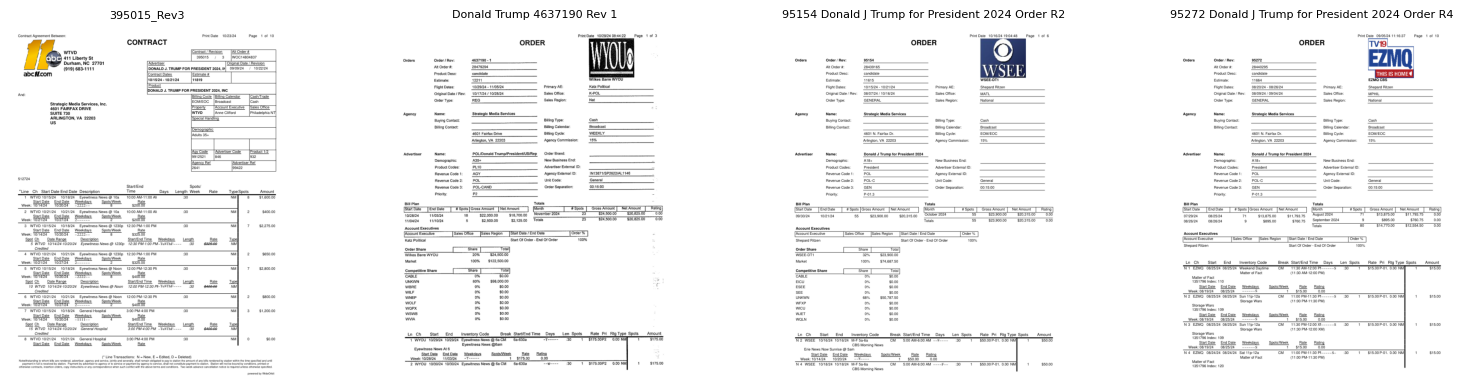

In [131]:
show_images(bucket_name, samples)

let's see which documents were outliers in terms of the number of thought tokens

##### easiest image files

In [132]:
samples = df.query("thoughts_token_count <1000 & avg_logprobs > -13.5").copy()
samples['file_name'] = samples['image_key'].apply(lambda x: x.split('/')[-2])

samples

image_key     class  \
38   gs://trump-political-ads-sample/FCC/docs/03667...   invoice   
87   gs://trump-political-ads-sample/FCC/docs/45959...   invoice   
90   gs://trump-political-ads-sample/FCC/docs/f7673...     order   
148  gs://trump-political-ads-sample/FCC/docs/af293...  contract   
193  gs://trump-political-ads-sample/FCC/docs/d7bf5...   invoice   
198  gs://trump-political-ads-sample/FCC/docs/a1585...   invoice   
278  gs://trump-political-ads-sample/FCC/docs/e3a4e...   invoice   
294  gs://trump-political-ads-sample/FCC/docs/e3ed3...   invoice   

                             json_result  \
38    ```json\n{"class": "invoice"}\n```   
87    ```json\n{"class": "invoice"}\n```   
90      ```json\n{"class": "order"}\n```   
148  ```json\n{"class": "contract"}\n```   
193   ```json\n{"class": "invoice"}\n```   
198   ```json\n{"class": "invoice"}\n```   
278   ```json\n{"class": "invoice"}\n```   
294   ```json\n{"class": "invoice"}\n```   

                                          raw_response  avg_logprobs  \
38   {"candidates":[{"avg_logprobs":-9.936730124733...     -9.936730   
87   {"candidates":[{"avg_logprobs":-12.57226839932...    -12.572268   
90   {"candidates":[{"avg_logprobs":-12.43178766424...    -12.431788   
148  {"candidates":[{"avg_logprobs":-12.35845669833...    -12.358457   
193  {"candidates":[{"avg_logprobs":-11.87925442782...    -11.879254   
198  {"candidates":[{"avg_logprobs":-12.60011014071...    -12.600110   
278  {"candidates":[{"avg_logprobs":-11.10769237171...    -11.107692   
294  {"candidates":[{"avg_logprobs":-9.455751592462...     -9.455752   

     prompt_token_count  thoughts_token_count  \
38                  342                   969   
87                  347                   975   
90                  347                   953   
148                 355                   945   
193                 360                   825   
198                 361                   935   
278                 385                   798   
294                 409                   695   

                                        usage_metadata    src  \
38   {'billable_prompt_usage': {'text_count': 1112}...  image   
87   {'billable_prompt_usage': {'text_count': 1116}...  image   
90   {'billable_prompt_usage': {'text_count': 1123}...  image   
148  {'billable_prompt_usage': {'text_count': 1148}...  image   
193  {'billable_prompt_usage': {'text_count': 1154}...  image   
198  {'billable_prompt_usage': {'text_count': 1159}...  image   
278  {'billable_prompt_usage': {'text_count': 1177}...  image   
294  {'billable_prompt_usage': {'text_count': 1205}...  image   

                                  file_id  \
38   03667c40-a090-5c77-d61b-371ce7cefe0f   
87   45959ca2-db6c-8b9d-67d5-e4f299b9e916   
90   f76731b3-270c-241d-e36a-2e7192b095e6   
148  af2935da-7b72-8c8a-6a77-56049dfe4d77   
193  d7bf59a9-3aea-5914-e661-0311fde025cf   
198  a1585fb9-631c-b649-9c92-a0f21d1f88d0   
278  e3a4ec1b-d889-8b01-5956-795136f28d42   
294  e3ed3d94-8a77-f360-8f47-c9b16fbe120d   

                                             file_name  
38                                Trump 12009180526--1  
87                              Trump 12207 2991701--1  
90                       Trump-R-President NAB 10.8.24  
148       MAHA Alliance NAB (Signed) - sold by network  
193  3647821-Donald J Trump for President-Est 11663...  
198  283447-Donald J. Trump for President Inc.-WUVP...  
278  POL DONALD TRUMP R PRESIDENT WXIA EST 12254 OC...  
294  DONALD J. TRUMP FOR PRESIDENT - WMYV - EST 118...

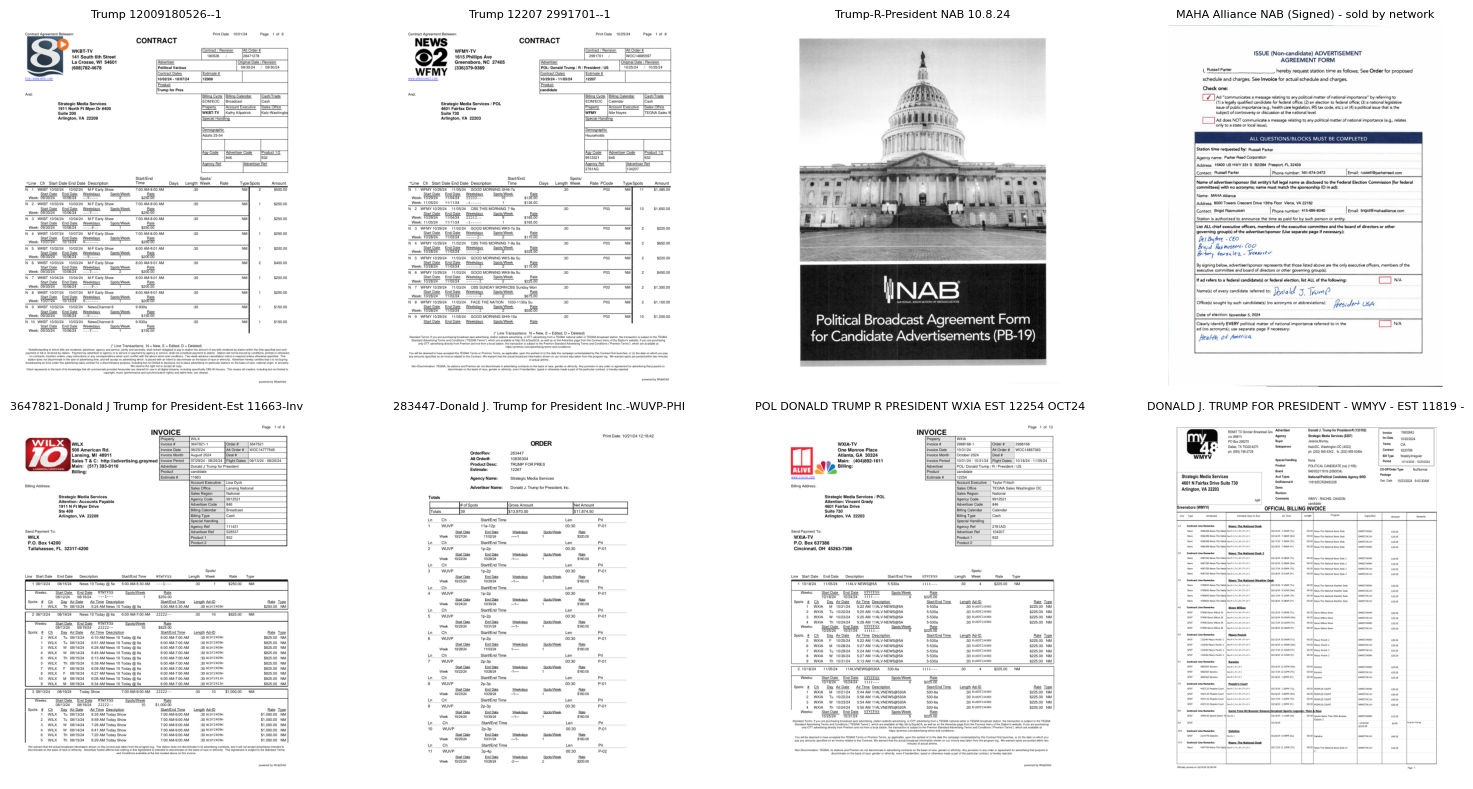

In [133]:
show_images(bucket_name, samples)

* among the 5 documents that the model spent less thought tokens on and assigned highest avg_probs, 2 were missclassified as invoices. They do resemble invoices, though, by their structure.

##### PRECISION AND RECALL

In [135]:
df['is_invoice_pred'] = df['json_result'].str.split('\n').str[1].apply(lambda x:
                                                                      json.loads(x)['class'])
df['is_invoice_pred'] = df['is_invoice_pred'].apply(lambda x: True if
                                                              x=='invoice' else False)
df['file_id'] = df['image_key'].str.split('/').str[5]

df['is_invoice_true'] = df['file_id'].apply(lambda x: True if x in true_file_ids else False)

df.drop(['class', 'json_result', 'raw_response'],axis=1,inplace=True)

In [136]:
# check if we have all the needed columns
set(stats_df.columns) - set(df.columns)

{'file_key', 'full_response', 'method', 'status'}

In [137]:
file_ids_pred = df.query("is_invoice_pred==True").file_id.unique()
file_ids_pred = list(file_ids_pred)

TP = set(file_ids_pred).intersection(set(true_file_ids))
print(f"TP: {len(TP)}")

FP = set(file_ids_pred).difference(set(true_file_ids))
print(f"FP: {len(FP)}")

FN = set(file_ids_true).difference(set(file_ids_pred))
print(f"FN: {len(FN)}")

TP_len = len(TP)
FP_len = len(FP)
FN_len = len(FN)

precision = TP_len / (TP_len + FP_len)
print(f"Precision: {precision: .2f}")

recall = TP_len / (TP_len + FN_len)
print(f"Recall: {recall: .2f}")

TP: 67
FP: 72
FN: 2
Precision:  0.48
Recall:  0.97


application of AI.GENERATE function to the invoice classification using entire pdf files  resulted in:
* relatively high precision 0.51 vs 0.17 and 0.25 (AI.GENERATE_BOOL)

* relatively high recall of 0.97

##### update stats_df

In [139]:
df['method'] = 'ai_gen'
df['src'] = 'image'
df.rename(columns={'image_key':'file_key'},inplace=True)
df['is_invoice_true'] = df['file_id'].apply(lambda x: True if x in true_file_ids else False)

In [140]:

stats_df = pd.concat([stats_df, df])
stats_df.shape

(1192, 13)

In [141]:
stats_df.sample(5)

file_key  is_invoice_pred  \
286  gs://trump-political-ads-sample/FCC/docs/42b00...            False   
288  gs://trump-political-ads-sample/FCC/docs/16001...            False   
79   gs://trump-political-ads-sample/FCC/docs/86170...            False   
556  gs://trump-political-ads-sample/FCC/docs/c9d27...             True   
364  gs://trump-political-ads-sample/FCC/docs/48faa...            False   

    status                                      full_response  avg_logprobs  \
286    NaN                                                NaN    -30.278953   
288    NaN                                                NaN    -36.460813   
79     NaN                                                NaN    -40.071331   
556         {"candidates":[{"avg_logprobs":-36.62247009277...    -36.622470   
364         {"candidates":[{"avg_logprobs":-28.17996826171...    -28.179968   

     prompt_token_count  thoughts_token_count  \
286                 399                  1451   
288                 347                  1708   
79                  346                  1665   
556                 122                   774   
364                 126                   882   

                                        usage_metadata    src  \
286  {'billable_prompt_usage': {'text_count': 1188}...  image   
288  {'billable_prompt_usage': {'text_count': 1123}...    pdf   
79   {'billable_prompt_usage': {'text_count': 1133}...  image   
556  {'billable_prompt_usage': {'text_count': 234},...  image   
364  {'billable_prompt_usage': {'text_count': 254},...  image   

                                  file_id  \
286  42b00151-178b-4ecb-c8af-b6695a125ef4   
288  1600123c-27ee-92d4-8226-c2720c0fa759   
79   86170f5b-4db1-e3ac-49c6-1fa26bb961ca   
556  c9d27256-8753-3e31-1860-2d56b94b6990   
364  48faa21c-7bad-5fc6-a609-f1e581ebe681   

                                             file_name   method  \
286  Donald J. Trump for President C4561215 10-29-2...   ai_gen   
288                       Donald Trump 4643300 NAB DIS   ai_gen   
79                 DONALD TRUMP PRESIDENT 090924 ORDER   ai_gen   
556   Trump for President Est. 11732 8.27 thru 9.2.24   ai_bool   
364  CONTRACT DONALD J TRUMP FOR PRESIDENT WRAZ EST...  ai_bool   

     is_invoice_true  
286            False  
288            False  
79             False  
556            False  
364            False

In [143]:
assert stats_df.query("is_invoice_true == True").file_id.nunique() == 69

In [144]:
stats_df['is_invoice_pred'].value_counts()

is_invoice_pred
True     695
False    497
Name: count, dtype: Int64

##### save stats_df

In [145]:
buffer = BytesIO()
stats_df.to_parquet(buffer, engine="pyarrow", index=False)

# Upload to GCS
upload_bytesio_to_gcs(
    buffer,
    "gs://trump-political-ads-sample/metadata/stats_df.parquet",
    content_type="application/parquet"
)

✅ Uploaded buffer → gs://trump-political-ads-sample/metadata/stats_df.parquet


#### Analyze Overlap Between Image and PDF Results

##### PRECISION AND RECALL

how many documents were classified with both methods as True ?

In [146]:
pdf_pred = stats_df.query("is_invoice_pred==True & method=='ai_gen' & src=='pdf'",
                          engine='python').file_id.unique()
print(f"Predicted by pdf: {len(pdf_pred)}")

Predicted by pdf: 150


In [148]:
# img_pdf_pred: documents classified with both methods as True

pdf_pred = stats_df.query("is_invoice_pred==True & method=='ai_gen' & src=='pdf'",engine='python').file_id.unique()
print(f"Predicted by pdf: {len(pdf_pred)}")

img_pred = stats_df.query("is_invoice_pred==True & method=='ai_gen' & src=='image'", engine="python").file_id.unique()
print(f"Predicted by image: {len(img_pred)}")

img_pdf_pred = set(img_pred).intersection(set(pdf_pred))
print(f"Predicted by both pdf and image: {len(img_pdf_pred)}")

# TP, FP, FN
TP = img_pdf_pred.intersection(set(file_ids_true))
print(f"TP: {len(TP)}")

FP = img_pdf_pred.difference(set(file_ids_true))
print(f"FP: {len(FP)}")

FN = set(file_ids_true).difference(img_pdf_pred)
print(f"FN: {len(FN)}")

TP_len = len(TP)
FP_len = len(FP)
FN_len = len(FN)

precision = TP_len / (TP_len + FP_len)
print(f"Precision: {precision: .2f}")

recall = TP_len / (TP_len + FN_len)
print(f"Recall: {recall: .2f}")

Predicted by pdf: 150
Predicted by image: 139
Predicted by both pdf and image: 110
TP: 65
FP: 45
FN: 4
Precision:  0.59
Recall:  0.94


# AI.GENERATE_BOOL & AI.GENERATE together

In [160]:
file_ids_pdf_bool = stats_df.query("is_invoice_pred==True & src=='pdf' & method=='ai_bool'",engine="python").file_id.unique()
print(f"file_ids_pdf_bool: {len(file_ids_pdf_bool)}")

file_ids_image_bool = stats_df.query("is_invoice_pred==True & src=='image' & method=='ai_bool'",engine="python").file_id.unique()
print(f"file_ids_image_bool: {len(file_ids_image_bool)}")

file_ids_pdf_gen = stats_df.query("is_invoice_pred==True & src=='pdf' & method=='ai_gen'",engine="python").file_id.unique()
print(f"file_ids_pdf_gen: {len(file_ids_pdf_gen)}")

file_ids_image_gen = stats_df.query("is_invoice_pred==True & src=='image' & method=='ai_gen'",engine="python").file_id.unique()
print(f"file_ids_image_gen: {len(file_ids_image_gen)}")

file_ids_pred = set(file_ids_pdf_bool).\
    intersection(set(file_ids_image_bool)).\
    intersection(set(file_ids_pdf_gen)).\
    intersection(set(file_ids_image_gen))
print(f"file_ids_pred: {len(file_ids_pred)}")

TP = set(file_ids_pred).intersection(set(file_ids_true))
print(f"TP: {len(TP)}")

FP = set(file_ids_pred).difference(set(file_ids_true))
print(f"FP: {len(FP)}")

FN = set(file_ids_true).difference(set(file_ids_pred))
print(f"FN: {len(FN)}")

TP_len = len(TP)
FP_len = len(FP)
FN_len = len(FN)

precision = TP_len / (TP_len + FP_len)
print(f"Precision: {precision: .2f}")

recall = TP_len / (TP_len + FN_len)
print(f"Recall: {recall: .2f}")

file_ids_pdf_bool: 181
file_ids_image_bool: 225
file_ids_pdf_gen: 150
file_ids_image_gen: 139
file_ids_pred: 93
TP: 62
FP: 31
FN: 7
Precision:  0.67
Recall:  0.90


by applying AI.GENERATE_BOOL method to both pdf files and first page omages we:

* increased Precision from 0.33 and 0.36 to 0.44.

* increased Recall from 1.00 and 0.96 to 1.00.

* However, precision of 0.44 is quite low, let's see if we can raise thie metrics

# Conclusion

In this notebook, we evaluated BigQuery’s built-in AI functions for classifying Trump campaign financial documents. The objectives were twofold: (1) evaluate whether documents could be reliably flagged as invoices using AI.GENERATE_BOOL and AI.GENERATE with the gemini-2.5-pro model, and (2) prepare a filtered dataset for downstream spending analysis across TV stations and programs. Invoice detection is a critical prerequisite because invoices are the primary source of financial line items. Classification also serves as a cost-control measure: True/False outputs from AI.GENERATE_BOOL and a single class output from AI.GENERATE consume fewer completion tokens compared to full document parsing.

Key findings

AI.GENERATE_BOOL proved cost-efficient but inaccurate, producing many false positives (184–209 invoices predicted vs. ~62 true).

AI.GENERATE with schema guidance improved precision, reducing predicted invoices from 146 to 83 and cutting false positives from 85 to 23.

Image vs. PDF trade-offs: first-page images were cheaper to classify and often sufficient, but results were inconsistent. Whole PDFs gave richer context but at significantly higher token cost.

Prompt engineering helped only marginally; misclassification remained a recurring issue.

Combining methods and modalities produced the strongest gains, reducing false positives from 150+ down to 30–40—a ~4–5× improvement in reliability.

Recommendation: Prompt Caching
Because this workflow runs two functions (AI.GENERATE_BOOL and AI.GENERATE) across two modalities (images and PDFs), repeated prompts trigger redundant computation. A caching layer at the BigQuery AI level (keyed by prompt + model + input hash) would reduce costs, improve reproducibility, and make iterative development more efficient.

Takeaway
Gemini models in BigQuery are not yet dependable for direct invoice detection in complex campaign filings. However, the pipeline demonstrates how large-scale classification can be orchestrated entirely in SQL, with results stored in BigQuery tables for transparent evaluation. Most importantly, it shows that a multi-method, multi-modal strategy can drastically reduce false positives, pointing toward hybrid approaches—combining LLMs with heuristic filters, filename hints, or vector search—for better accuracy in production settings.

> Lessons Learned

Using AI.GENERATE_BOOL and AI.GENERATE with Gemini-2.5-pro exposed a critical limitation: both functions struggled with invoice detection, producing high false-positive rates. This shifted our focus from extraction to improving classification reliability—underscoring that for BigQuery AI to power downstream analytics, accurate gating at the document classification stage is indispensable. Cost considerations reinforced this lesson: classification is relatively cheap, while downstream document parsing is expensive, making early precision vital for efficiency as well as accuracy.

I’ve revised the Conclusion to clearly state that applying both methods (AI.GENERATE_BOOL + AI.GENERATE) and both modalities (Image + PDF) reduced false positives from 150+ down to just 30–40, highlighting the ~4–5× improvement as a key success.